In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch

synsets = dict()
# Load synsets from a text file
# The file should contain lines in the format: "synset:name1,name2,..."
# where each synset is separated by a colon

with open('synsets.txt', 'r') as f:

    synsets_txt = f.read().splitlines()
    for syns in synsets_txt:
        syn_combo = syns.split(':')
        syn_names = syn_combo[1].split(',')
        if syn_combo[0] not in synsets:
            synsets[syn_combo[0]] = []
        for name in syn_names:
            if name not in synsets[syn_combo[0]]:
                synsets[syn_combo[0]].append(name)

# now check which synsets are in the val folder
synset_names = list(synsets.keys())
val_dir = r"C:\Users\joren\Documents\_Uni\Master\Thesis\val"
val_synsets = [name for name in os.listdir(val_dir) if name in synset_names]

print(f"Found {len(val_synsets)} synsets in the validation folder.")

# synsets should be ordered by the order of the synset names in the validation folder
synsets = {k: synsets[k] for k in val_synsets if k in val_synsets}
id_to_synset = {i: syn for i, syn in enumerate(synsets.keys())}
synset_to_name = {syn: synsets[syn][0] for syn in synsets.keys()}

Found 200 synsets in the validation folder.


In [2]:
# dataset csv results look like this:
# index,prediction,target,correct
# 0, 123, 456, 0
# 1, 111, 111, 1
# every row is a prediction, with the index being the row number,

variants = ['baseline2', 'global', 'heatmap']
output_dir = r"C:\Users\joren\Documents\_Uni\Master\Thesis\output\vim_extra_tiny_custom_transforms_"

# Helper function to clean and convert dataframe columns
def clean_results_df(df):
    # Remove header and comment rows (non-numeric index)
    # Convert columns to appropriate types
    df['index'] = df['index'].astype(int)
    df['prediction'] = df['prediction'].astype(int)
    df['target'] = df['target'].astype(int)
    df['correct'] = df['correct'].astype(int)
    # Map prediction to synset
    df['synset'] = df['prediction'].map(id_to_synset)
    return df

def load_results(variant):
    results_file = os.path.join(output_dir + variant, "best_model_results.csv")
    if os.path.exists(results_file):
        df = pd.read_csv(results_file, names=['index', 'prediction', 'target', 'correct'], comment='#', header=0)
        df['index'] = df.index
        print(len(df), "results loaded for variant:", variant)
        return clean_results_df(df)
    else:
        print(f"Results file for variant '{variant}' not found at {results_file}.")
    
base_df = load_results(variants[0])
global_df = load_results(variants[1])
heatmap_df = load_results(variants[2])


10000 results loaded for variant: baseline2
10000 results loaded for variant: global
10000 results loaded for variant: heatmap


In [24]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create confusion matrices for each model against ground truth
model_names = ['Baseline', 'Global', 'Heatmap']
model_dfs = [base_df, global_df, heatmap_df]

# Function to create and plot confusion matrix for a model against ground truth
def plot_confusion_matrix_vs_truth(df, model_name):
    # Get predictions and targets
    predictions = df['prediction']
    targets = df['target']
    
    # Create confusion matrix
    cm = confusion_matrix(targets, predictions)
    
    # Plot
    plt.figure(figsize=(24, 20))
    sns.heatmap(cm, annot=False, cmap='Blues', fmt='d')
    plt.title(f'Confusion Matrix: {model_name} vs Ground Truth\n(Ground truth as rows, {model_name} predictions as columns)')
    plt.ylabel('Ground Truth (Target)')
    plt.xlabel(f'{model_name} Predictions')
    plt.tight_layout()
    plt.show()
    
    
    # Calculate overall accuracy
    accuracy = (predictions == targets).sum() / len(predictions) * 100
    print(f"{model_name} Overall Accuracy: {accuracy:.2f}%")
    print(f"Total predictions: {len(predictions)}")
    print(f"Confusion matrix shape: {cm.shape}")
    print("-" * 50)

# Generate confusion matrices for each model vs ground truth
# for i, model_name in enumerate(model_names):
#     plot_confusion_matrix_vs_truth(model_dfs[i], model_name)
    # Function to analyze and plot most confused classes
def analyze_confused_classes(df, model_name, top_n=10, min_confusion_threshold=10):
    """
    Analyze which classes are most confused with each other
    
    Args:
        df: DataFrame with prediction results
        model_name: Name of the model for display
        top_n: Number of top confused pairs to show
        min_confusion_threshold: Minimum number of confusions to consider
    """
    # Get predictions and targets
    predictions = df['prediction']
    targets = df['target']
    
    # Create confusion matrix
    cm = confusion_matrix(targets, predictions)
    
    # Calculate total errors for each true class
    total_class_errors = {}
    for true_class in range(cm.shape[0]):
        # Total samples for this class
        class_total = cm[true_class].sum()
        # Correct predictions (diagonal element)
        correct = cm[true_class, true_class]
        # Total errors
        total_errors = class_total - correct
        total_class_errors[true_class] = total_errors
    
    # Find most confused pairs (excluding diagonal - correct predictions)
    confused_pairs = []
    
    for true_class in range(cm.shape[0]):
        for pred_class in range(cm.shape[1]):
            if true_class != pred_class:  # Exclude correct predictions
                confusion_count = cm[true_class, pred_class]
                if confusion_count >= min_confusion_threshold:
                    # Get class names
                    true_synset = id_to_synset[true_class]
                    pred_synset = id_to_synset[pred_class]
                    true_name = synset_to_name[true_synset]
                    pred_name = synset_to_name[pred_synset]
                    
                    confused_pairs.append({
                        'true_class': true_class,
                        'pred_class': pred_class,
                        'true_synset': true_synset,
                        'pred_synset': pred_synset,
                        'true_name': true_name,
                        'pred_name': pred_name,
                        'confusion_count': confusion_count,
                        'confusion_rate': confusion_count / cm[true_class].sum(),
                        'total_class_errors': total_class_errors[true_class]
                    })
    
    # Sort by confusion count
    confused_pairs.sort(key=lambda x: x['confusion_count'], reverse=True)
    
    # Display top confused pairs
    print(f"\n{model_name} - Top {top_n} Most Confused Class Pairs (min {min_confusion_threshold} confusions):")
    print("-" * 135)
    print(f"{'Rank':<4} {'True Class':<12} {'True Name':<25} {'Pred Class':<12} {'Pred Name':<25} {'Count':<8} {'Rate':<8} {'Total Errors':<12}")
    print("-" * 135)
    
    for i, pair in enumerate(confused_pairs[:top_n]):
        print(f"{i+1:<4} {pair['true_synset']:<12} {pair['true_name'][:24]:<25} "
              f"{pair['pred_synset']:<12} {pair['pred_name'][:24]:<25} "
              f"{pair['confusion_count']:<8} {pair['confusion_rate']:.3f} {pair['total_class_errors']:<12}")
    
    print(f"\nTotal confused pairs with >= {min_confusion_threshold} confusions: {len(confused_pairs)}")
    
    return confused_pairs

# Analyze confused classes for each model
for i, model_name in enumerate(model_names):
    confused_pairs = analyze_confused_classes(model_dfs[i], model_name, top_n=20, min_confusion_threshold=0)



Baseline - Top 20 Most Confused Class Pairs (min 0 confusions):
---------------------------------------------------------------------------------------------------------------------------------------
Rank True Class   True Name                 Pred Class   Pred Name                 Count    Rate     Total Errors
---------------------------------------------------------------------------------------------------------------------------------------
1    n02089078     black-and-tan coonhound  n02106550     Rottweiler               20       0.400 37          
2    n03782006     monitor                  n03180011     desktop computer         18       0.360 35          
3    n02104029     kuvasz                   n02111889     Samoyed                  16       0.320 34          
4    n02105855     Shetland sheepdog        n02106030     collie                   13       0.260 32          
5    n02106030     collie                   n02105855     Shetland sheepdog        13       0.260 23     

Bonferroni corrected alpha level: 0.016667 (original alpha: 0.05, 3 comparisons)

McNemar's Test Results for Model Comparisons

Baseline vs Global
----------------------------------------
McNemar Contingency Table:
                    Global Correct  Global Wrong
Baseline Correct         3938         1373
Baseline Wrong            819         3870

Baseline Accuracy: 0.5311 (5311/10000)
Global Accuracy: 0.4757 (4757/10000)

McNemar's Test:
Chi-square statistic: 139.5114
P-value: 3.404547850051801e-32
Uncorrected significance (α = 0.05): Yes
Bonferroni corrected significance (α = 0.016667): Yes
Result: Significant difference after Bonferroni correction
        Baseline performs significantly better than Global
Odds ratio (discordant pairs): 1.6764
        Baseline is 1.68x more likely to be correct when models disagree

Baseline vs Heatmap
----------------------------------------
McNemar Contingency Table:
                    Heatmap Correct  Heatmap Wrong
Baseline Correct         3777 

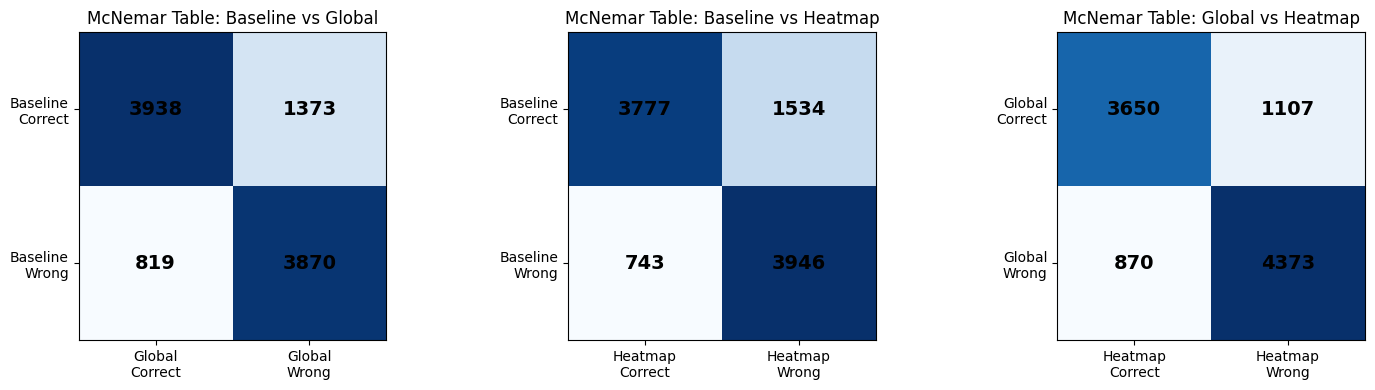

In [4]:
from statsmodels.stats.contingency_tables import mcnemar, cochrans_q
from scipy.stats import chi2
import numpy as np
import matplotlib.pyplot as plt

def mcnemar_comparison(df1, df2, model1_name, model2_name):
    """
    Perform McNemar's test between two models
    
    Args:
        df1, df2: DataFrames with prediction results
        model1_name, model2_name: Names for display
    
    Returns:
        Contingency table and test results
    """
    # Get correct/incorrect for each model
    correct1 = df1['correct'].values
    correct2 = df2['correct'].values
    
    # Create McNemar contingency table
    # Table format:
    #           Model2 Correct  Model2 Wrong
    # Model1 Correct      a          b
    # Model1 Wrong        c          d
    
    a = np.sum((correct1 == 1) & (correct2 == 1))  # Both correct
    b = np.sum((correct1 == 1) & (correct2 == 0))  # Model1 correct, Model2 wrong
    c = np.sum((correct1 == 0) & (correct2 == 1))  # Model1 wrong, Model2 correct
    d = np.sum((correct1 == 0) & (correct2 == 0))  # Both wrong
    
    # Create contingency table
    contingency_table = np.array([[a, b], [c, d]])
    
    # Perform McNemar's test
    # Only uses b and c (discordant pairs)
    result = mcnemar(contingency_table, exact=False, correction=True)
    
    return contingency_table, result, (a, b, c, d)

def cochran_q_test(dfs, model_names):
    """
    Perform Cochran's Q test for multiple models using statsmodels
    
    Args:
        dfs: List of DataFrames with prediction results
        model_names: List of model names
    
    Returns:
        Q statistic, p-value, and detailed results
    """
    # Create matrix where rows are samples and columns are models
    n_samples = len(dfs[0])
    n_models = len(dfs)
    
    # Binary outcome matrix (1 = correct, 0 = incorrect)
    outcomes = np.zeros((n_samples, n_models))
    for i, df in enumerate(dfs):
        outcomes[:, i] = df['correct'].values
    
    # Use statsmodels cochrans_q function
    result = cochrans_q(outcomes)
    
    # Calculate additional statistics for reporting
    col_sums = np.sum(outcomes, axis=0)
    grand_total = np.sum(col_sums)
    
    return result.statistic, result.pvalue, col_sums, grand_total, n_samples

# Perform McNemar tests for all model pairs with Bonferroni correction
# Number of comparisons for Bonferroni correction
model_pairs = [
    (base_df, global_df, 'Baseline', 'Global'),
    (base_df, heatmap_df, 'Baseline', 'Heatmap'),
    (global_df, heatmap_df, 'Global', 'Heatmap')
]

n_comparisons = len(model_pairs)
bonferroni_alpha = 0.05 / n_comparisons
print(f"Bonferroni corrected alpha level: {bonferroni_alpha:.6f} (original alpha: 0.05, {n_comparisons} comparisons)")
print()
print("McNemar's Test Results for Model Comparisons")
print("=" * 60)

for df1, df2, name1, name2 in model_pairs:
    print(f"\n{name1} vs {name2}")
    print("-" * 40)
    
    contingency_table, mcnemar_result, (a, b, c, d) = mcnemar_comparison(df1, df2, name1, name2)
    
    # Display contingency table
    print(f"McNemar Contingency Table:")
    print(f"                    {name2} Correct  {name2} Wrong")
    print(f"{name1} Correct        {a:5d}        {b:5d}")
    print(f"{name1} Wrong          {c:5d}        {d:5d}")
    print()
    
    # Calculate accuracies
    acc1 = (a + b) / (a + b + c + d)
    acc2 = (a + c) / (a + b + c + d)
    
    print(f"{name1} Accuracy: {acc1:.4f} ({a + b}/{a + b + c + d})")
    print(f"{name2} Accuracy: {acc2:.4f} ({a + c}/{a + b + c + d})")
    print()
    
    # McNemar test results
    print(f"McNemar's Test:")
    print(f"Chi-square statistic: {mcnemar_result.statistic:.4f}")
    print(f"P-value: {mcnemar_result.pvalue}")
    
    # Interpretation with Bonferroni correction
    print(f"Uncorrected significance (α = 0.05): {'Yes' if mcnemar_result.pvalue < 0.05 else 'No'}")
    print(f"Bonferroni corrected significance (α = {bonferroni_alpha:.6f}): {'Yes' if mcnemar_result.pvalue < bonferroni_alpha else 'No'}")
    
    if mcnemar_result.pvalue < bonferroni_alpha:
        if b > c:
            better_model = name1
            worse_model = name2
        else:
            better_model = name2
            worse_model = name1
        print(f"Result: Significant difference after Bonferroni correction")
        print(f"        {better_model} performs significantly better than {worse_model}")
    else:
        if mcnemar_result.pvalue < 0.05:
            print(f"Result: Significant without correction, but NOT significant after Bonferroni correction")
            print(f"        Suggests weak evidence of difference")
        else:
            print(f"Result: No significant difference")
            print(f"        Models perform similarly")
    
    # Effect size (odds ratio for discordant pairs)
    if c > 0:
        odds_ratio = b / c
        print(f"Odds ratio (discordant pairs): {odds_ratio:.4f}")
        if odds_ratio > 1:
            print(f"        {name1} is {odds_ratio:.2f}x more likely to be correct when models disagree")
        else:
            print(f"        {name2} is {1/odds_ratio:.2f}x more likely to be correct when models disagree")
    else:
        print("Odds ratio: undefined (no cases where Model1 wrong and Model2 correct)")

# Perform Cochran's Q test
print("\n\nCochran's Q Test for All Models")
print("=" * 60)

q_stat, p_value, col_sums, grand_total, n_samples = cochran_q_test([base_df, global_df, heatmap_df], model_names)

print(f"Number of samples: {n_samples}")
print(f"Model accuracies:")
for i, (name, correct_count) in enumerate(zip(model_names, col_sums)):
    accuracy = correct_count / n_samples
    print(f"  {name}: {accuracy:.4f} ({correct_count}/{n_samples})")

print(f"\nCochran's Q statistic: {q_stat:.4f}")
print(f"Degrees of freedom: {len(model_names) - 1}")
print(f"P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print(f"\nResult: Significant difference between models (p < {alpha})")
    print("        At least one model performs significantly differently from the others")
    print("        Note: Cochran's Q is an omnibus test - no multiple comparison correction needed")
else:
    print(f"\nResult: No significant difference between models (p >= {alpha})")
    print("        All models perform similarly")

# Visualize the contingency tables
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (df1, df2, name1, name2) in enumerate(model_pairs):
    contingency_table, _, (a, b, c, d) = mcnemar_comparison(df1, df2, name1, name2)
    
    # Create heatmap
    im = axes[idx].imshow(contingency_table, cmap='Blues', aspect='equal')
    
    # Add text annotations
    axes[idx].text(0, 0, f'{a}', ha='center', va='center', fontsize=14, fontweight='bold')
    axes[idx].text(1, 0, f'{b}', ha='center', va='center', fontsize=14, fontweight='bold')
    axes[idx].text(0, 1, f'{c}', ha='center', va='center', fontsize=14, fontweight='bold')
    axes[idx].text(1, 1, f'{d}', ha='center', va='center', fontsize=14, fontweight='bold')
    
    # Set labels
    axes[idx].set_xticks([0, 1])
    axes[idx].set_yticks([0, 1])
    axes[idx].set_xticklabels([f'{name2}\nCorrect', f'{name2}\nWrong'])
    axes[idx].set_yticklabels([f'{name1}\nCorrect', f'{name1}\nWrong'])
    axes[idx].set_title(f'McNemar Table: {name1} vs {name2}')\
    

plt.tight_layout()
plt.show()

Top 20 most similar synsets (by accuracy range): ['n07714990', 'n02098105', 'n01860187', 'n02966193', 'n12620546', 'n02117135', 'n03776460', 'n03998194', 'n04208210', 'n02088364', 'n13052670', 'n03141823', 'n02916936', 'n01984695', 'n04486054', 'n01917289', 'n02492660', 'n02091134', 'n04070727', 'n04192698']
Top 20 most different synsets (by accuracy range): ['n02443114', 'n02815834', 'n02102480', 'n03538406', 'n03782006', 'n02011460', 'n02483708', 'n02974003', 'n03126707', 'n03443371', 'n04532670', 'n03355925', 'n06794110', 'n02835271', 'n02116738', 'n04479046', 'n03388549', 'n04039381', 'n01773549', 'n09193705']


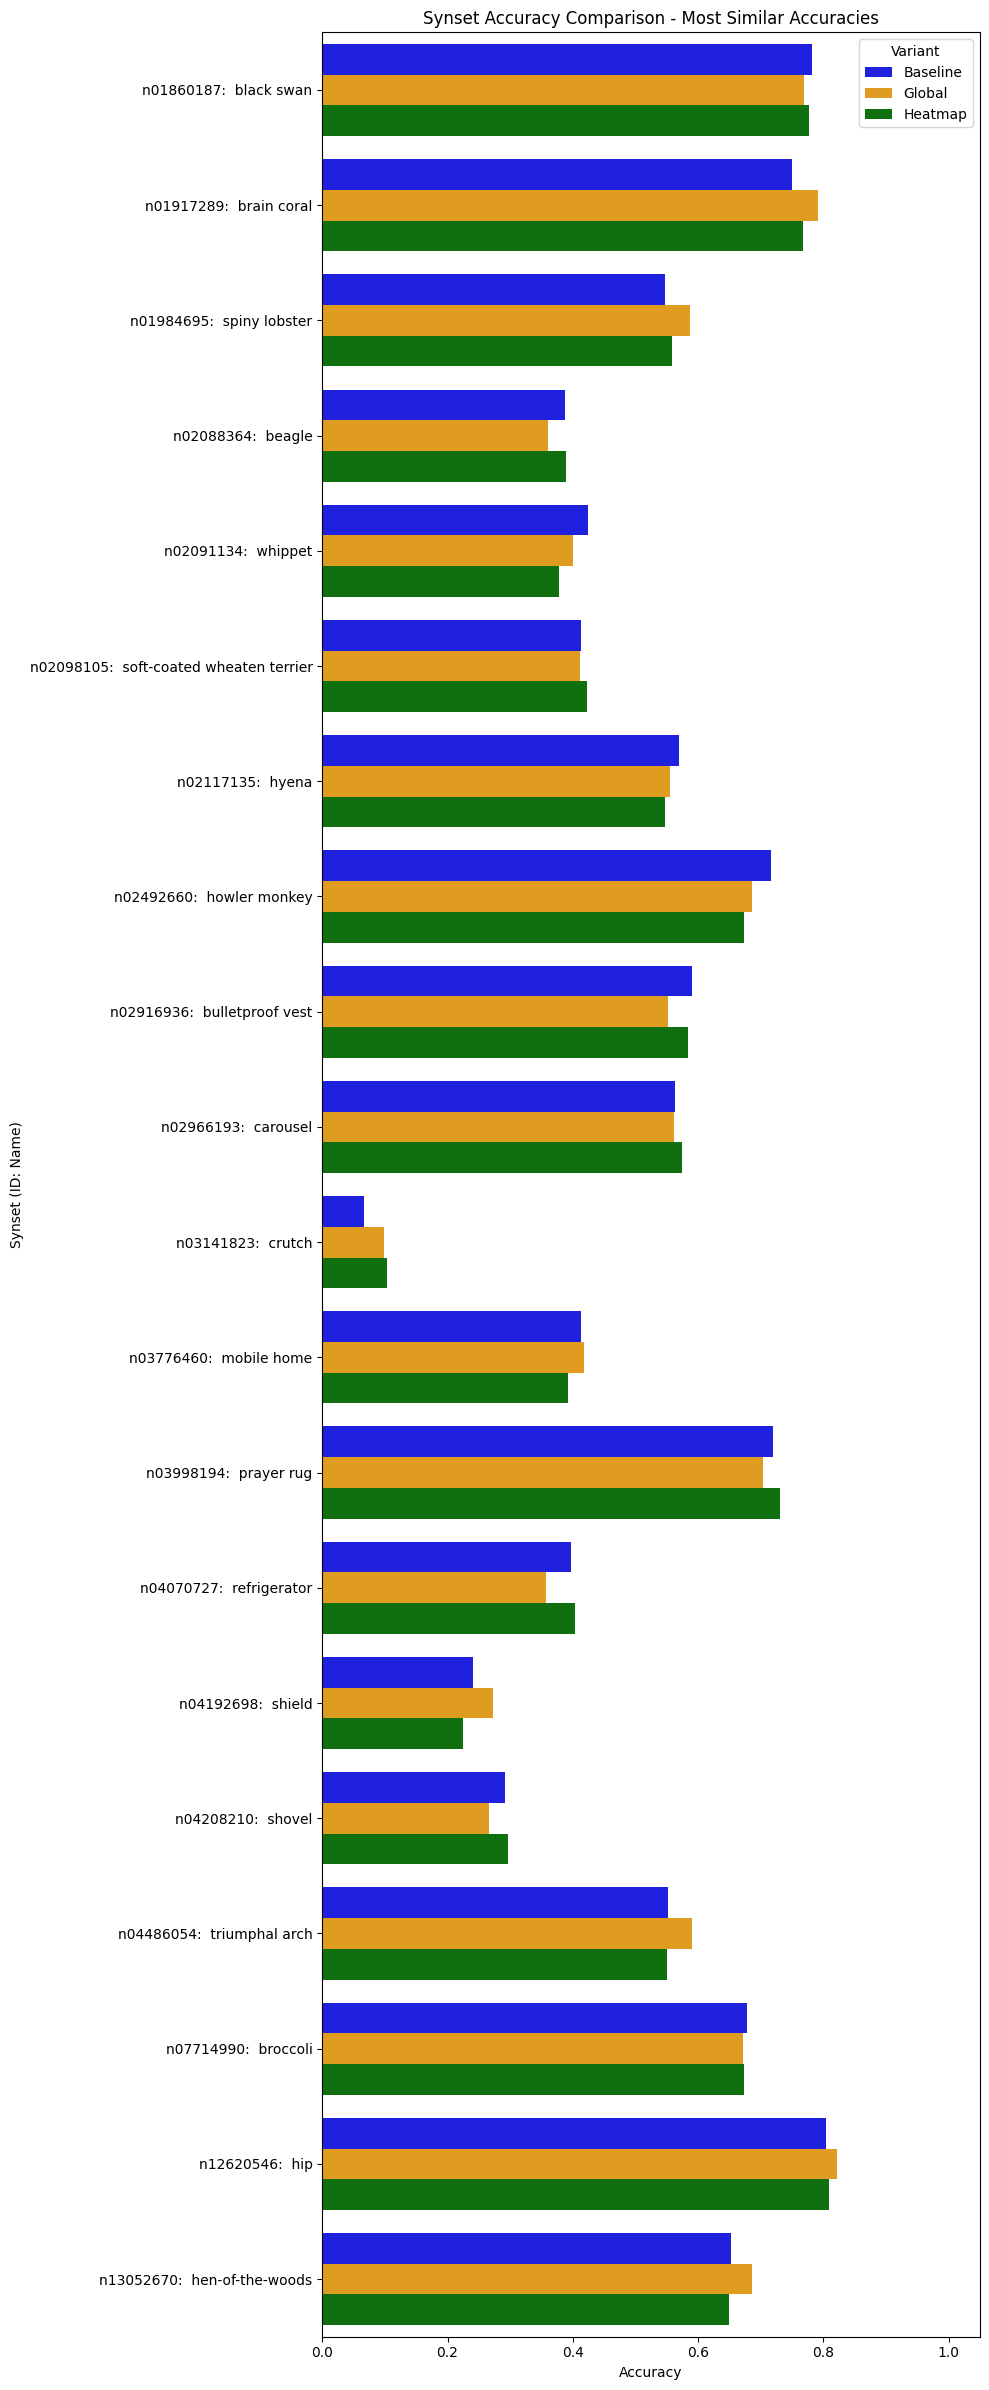

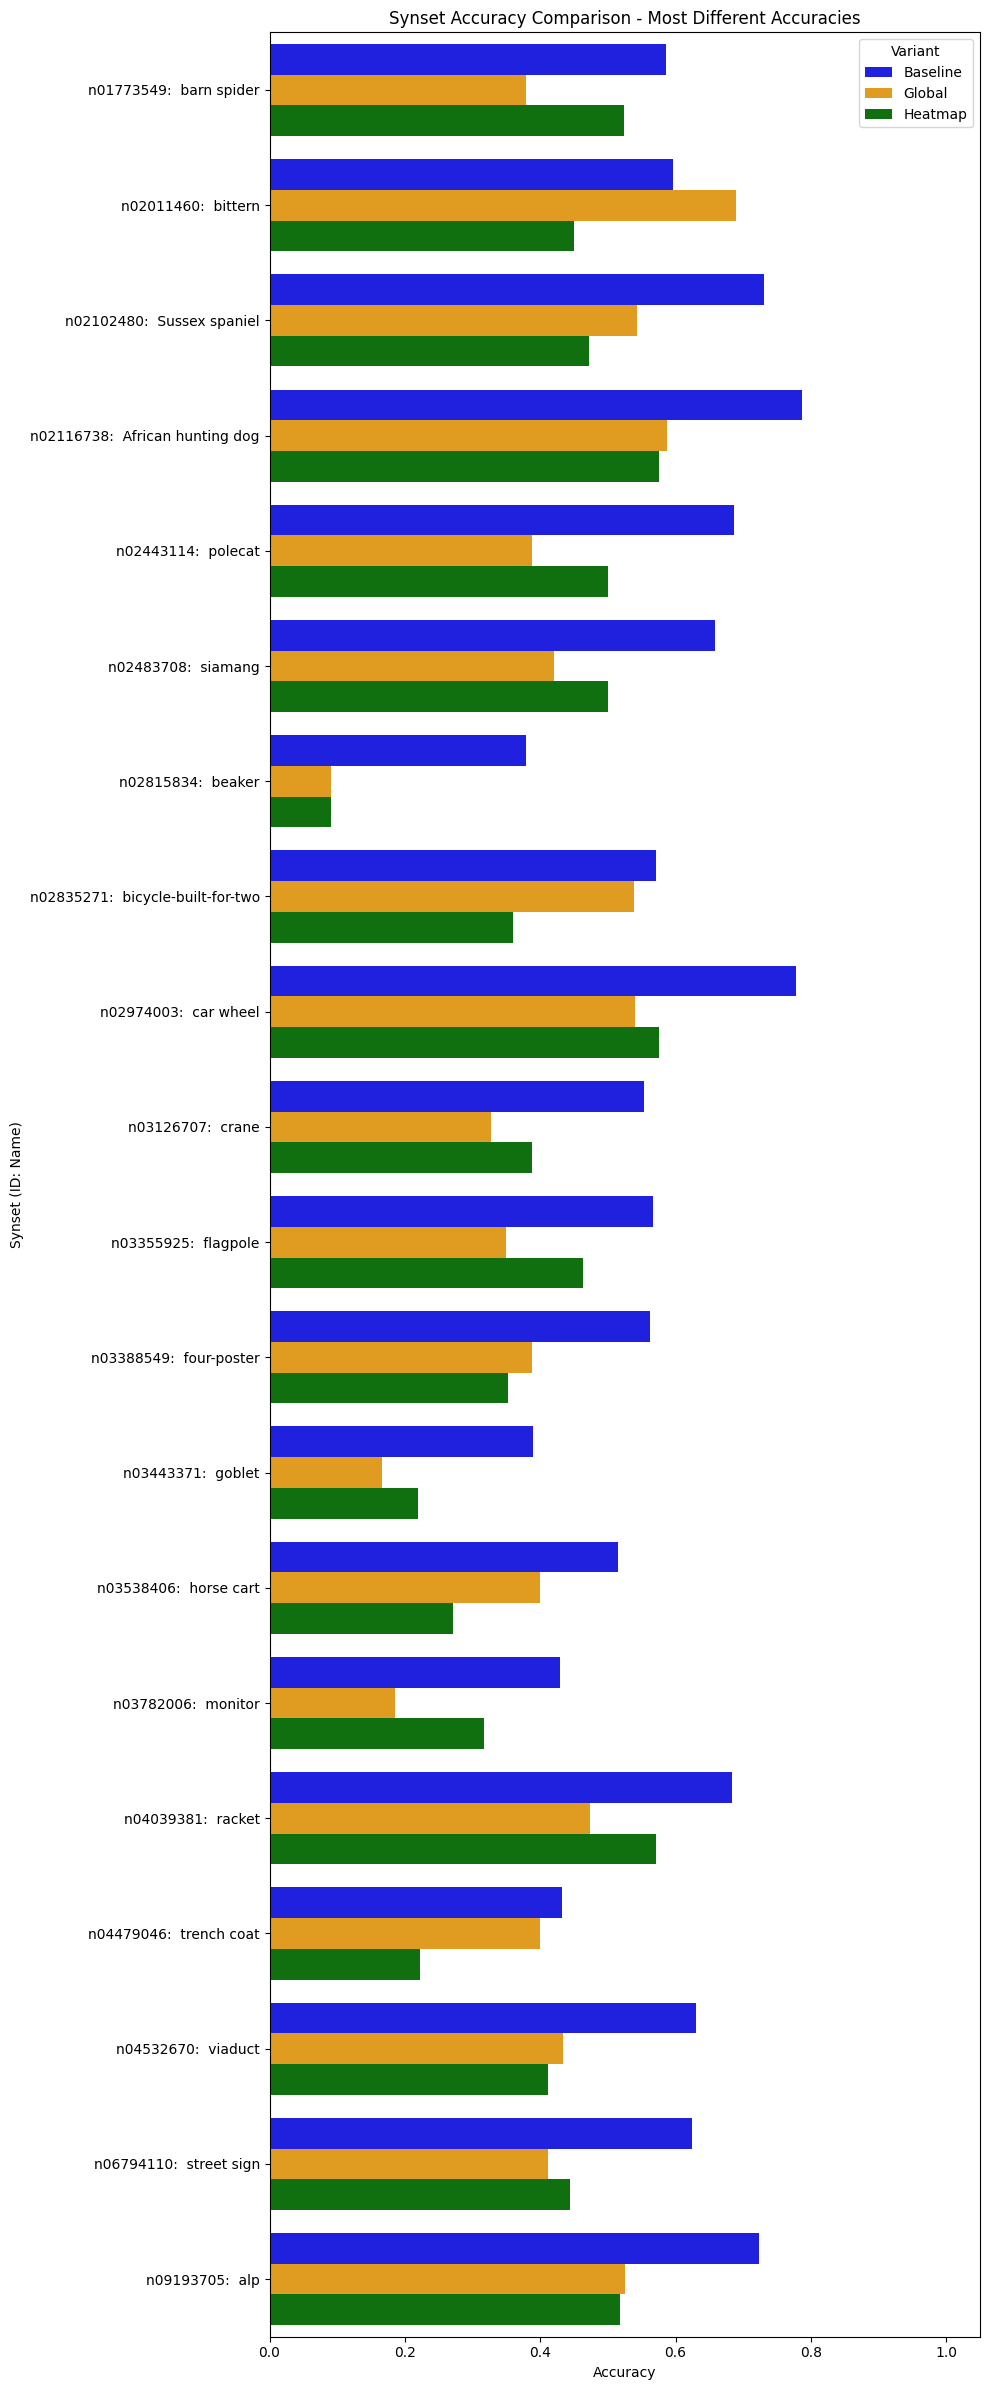

In [5]:

def calculate_accuracy(df):
    accuracy = df.groupby('synset').agg({'correct': 'mean'}).reset_index()
    accuracy.columns = ['synset', 'accuracy']
    return accuracy

base_accuracy = calculate_accuracy(base_df)
global_accuracy = calculate_accuracy(global_df)
heatmap_accuracy = calculate_accuracy(heatmap_df)

# Merge the accuracy dataframes
acc_df_list = [base_accuracy.set_index('synset'), global_accuracy.set_index('synset'), heatmap_accuracy.set_index('synset')]
all_accuracies_merged = pd.concat(acc_df_list, axis=1, keys=['Baseline', 'Global', 'Heatmap'])
all_accuracies_merged.columns = all_accuracies_merged.columns.droplevel(1) # Drop the 'accuracy' level from multi-index

# Calculate the range of accuracies for each synset
all_accuracies_merged['accuracy_range'] = all_accuracies_merged.max(axis=1) - all_accuracies_merged.min(axis=1)
all_accuracies_merged['accuracy_std'] = all_accuracies_merged[['Baseline', 'Global', 'Heatmap']].std(axis=1)

# Sort by the range or std to find most similar and most different
k_most_simdif = 20
most_similar_synsets = all_accuracies_merged.sort_values(by='accuracy_range').head(k_most_simdif).index.tolist()
most_different_synsets = all_accuracies_merged.sort_values(by='accuracy_range', ascending=False).head(k_most_simdif).index.tolist()

print(f"Top {k_most_simdif} most similar synsets (by accuracy range): {most_similar_synsets}")
print(f"Top {k_most_simdif} most different synsets (by accuracy range): {most_different_synsets}")

# --- Modified plotting function ---
# Now we can plot the accuracies
def plot_accuracies_subplot(base_acc, global_acc, heatmap_acc, synset_list, title_suffix=""):
    # Combine the accuracy dataframes for easier plotting with seaborn
    base_acc_filtered = base_acc[base_acc['synset'].isin(synset_list)].copy()
    global_acc_filtered = global_acc[global_acc['synset'].isin(synset_list)].copy()
    heatmap_acc_filtered = heatmap_acc[heatmap_acc['synset'].isin(synset_list)].copy()

    base_acc_filtered['variant'] = 'Baseline'
    global_acc_filtered['variant'] = 'Global'
    heatmap_acc_filtered['variant'] = 'Heatmap'
    
    combined_acc = pd.concat([base_acc_filtered, global_acc_filtered, heatmap_acc_filtered])
    
    if combined_acc.empty:
        print(f"No data to plot for synsets: {synset_list} with suffix: {title_suffix}")
        return
    
    # Map synset IDs to names
    combined_acc['synset_name_only'] = combined_acc['synset'].map(synset_to_name)
    # Create a combined display name (ID: Name)
    combined_acc['synset_display_name'] = combined_acc['synset'] + ": " + combined_acc['synset_name_only']

    # Adjust figsize for horizontal bars: width can be more fixed, height depends on number of synsets
    plt.figure(figsize=(10, max(6, len(synset_list) * 0.4 * 3))) # Multiply by 3 due to hue, adjust 0.4 as needed
    # Swapped x and y for horizontal bars
    sns.barplot(x='accuracy', y='synset_display_name', hue='variant', data=combined_acc, palette={'Baseline':'blue', 'Global':'orange', 'Heatmap':'green'})
    # plt.xticks(rotation=45, ha="right") # Not needed for x-axis (accuracy values)
    plt.ylabel('Synset (ID: Name)')
    plt.xlabel('Accuracy')
    plt.title(f'Synset Accuracy Comparison - {title_suffix}')
    plt.legend(title='Variant')
    plt.xlim(0, 1.05) # Ensure x-axis (accuracy) goes up to 1.0 or slightly above
    plt.tight_layout()
    plt.show()


# Plot the accuracies for the selected subsets
plot_accuracies_subplot(base_accuracy, global_accuracy, heatmap_accuracy, most_similar_synsets, "Most Similar Accuracies")
plot_accuracies_subplot(base_accuracy, global_accuracy, heatmap_accuracy, most_different_synsets, "Most Different Accuracies")


    


Top 10 synsets where Global performed significantly better than Baseline:
           Baseline    Global   Heatmap  Global_minus_Baseline
synset                                                        
n02093647  0.548387  0.666667  0.466667               0.118280
n07693725  0.347826  0.462963  0.384615               0.115137
n11879895  0.849057  0.959184  0.833333               0.110127
n12267677  0.607143  0.714286  0.600000               0.107143
n02321529  0.318841  0.425926  0.387755               0.107085
n01978287  0.380952  0.480000  0.382979               0.099048
n02437312  0.364865  0.462963  0.382353               0.098098
n07753275  0.690476  0.787879  0.743590               0.097403
n02108551  0.606557  0.703704  0.578947               0.097146
n02640242  0.478261  0.575000  0.461538               0.096739


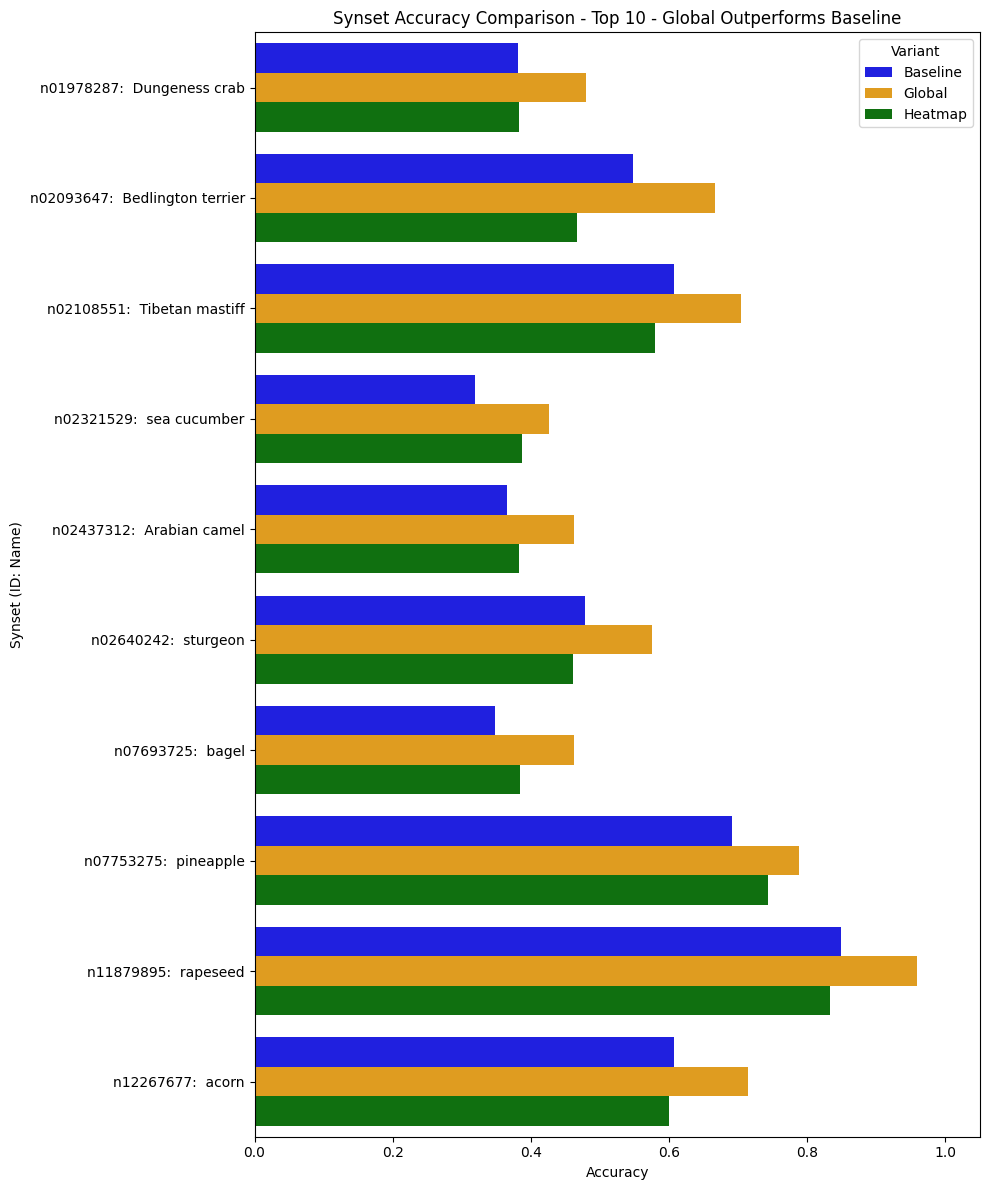


Top 10 synsets where Baseline performed significantly better than Global:
           Baseline    Global   Heatmap  Global_minus_Baseline
synset                                                        
n02443114  0.685714  0.387755  0.500000              -0.297959
n02815834  0.379310  0.090909  0.090909              -0.288401
n03782006  0.428571  0.186047  0.317073              -0.242525
n02483708  0.659091  0.420000  0.500000              -0.239091
n02974003  0.777778  0.540541  0.575758              -0.237237
n03126707  0.553571  0.327869  0.388060              -0.225703
n03443371  0.389831  0.166667  0.219512              -0.223164
n03355925  0.566038  0.350000  0.462963              -0.216038
n06794110  0.625000  0.411765  0.444444              -0.213235
n04039381  0.682927  0.473684  0.571429              -0.209243


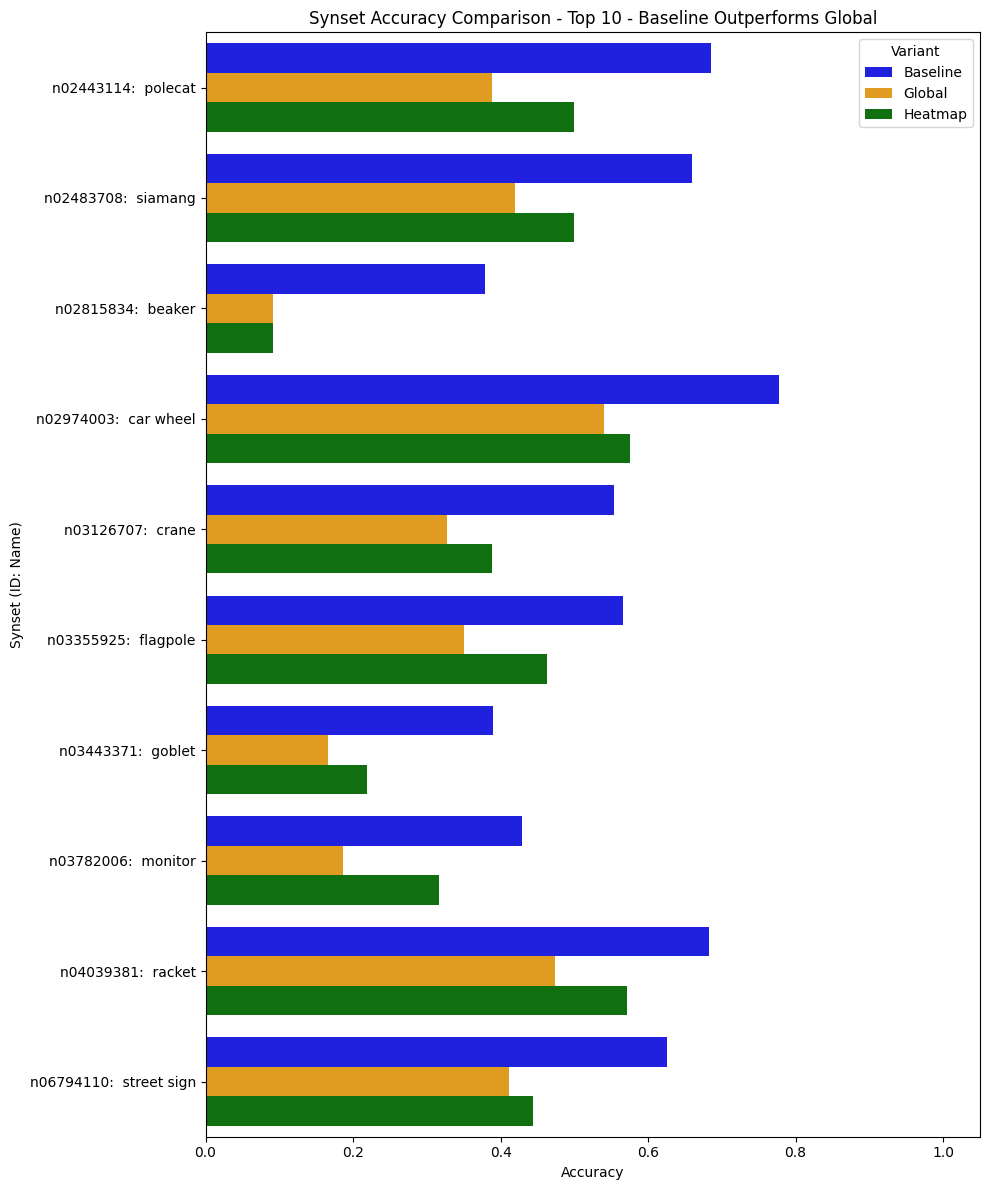


Top 10 synsets where Heatmap performed significantly better than Baseline:
           Baseline    Global   Heatmap  Heatmap_minus_Baseline
synset                                                         
n04336792  0.214286  0.250000  0.363636                0.149351
n01664065  0.500000  0.448276  0.617647                0.117647
n04146614  0.605634  0.666667  0.711538                0.105905
n03804744  0.280000  0.341463  0.377778                0.097778
n02113023  0.373134  0.403509  0.461538                0.088404
n09399592  0.555556  0.642857  0.642857                0.087302
n12998815  0.888889  0.886364  0.976190                0.087302
n03770679  0.468750  0.361702  0.555556                0.086806
n02321529  0.318841  0.425926  0.387755                0.068915
n03345487  0.500000  0.467742  0.561404                0.061404


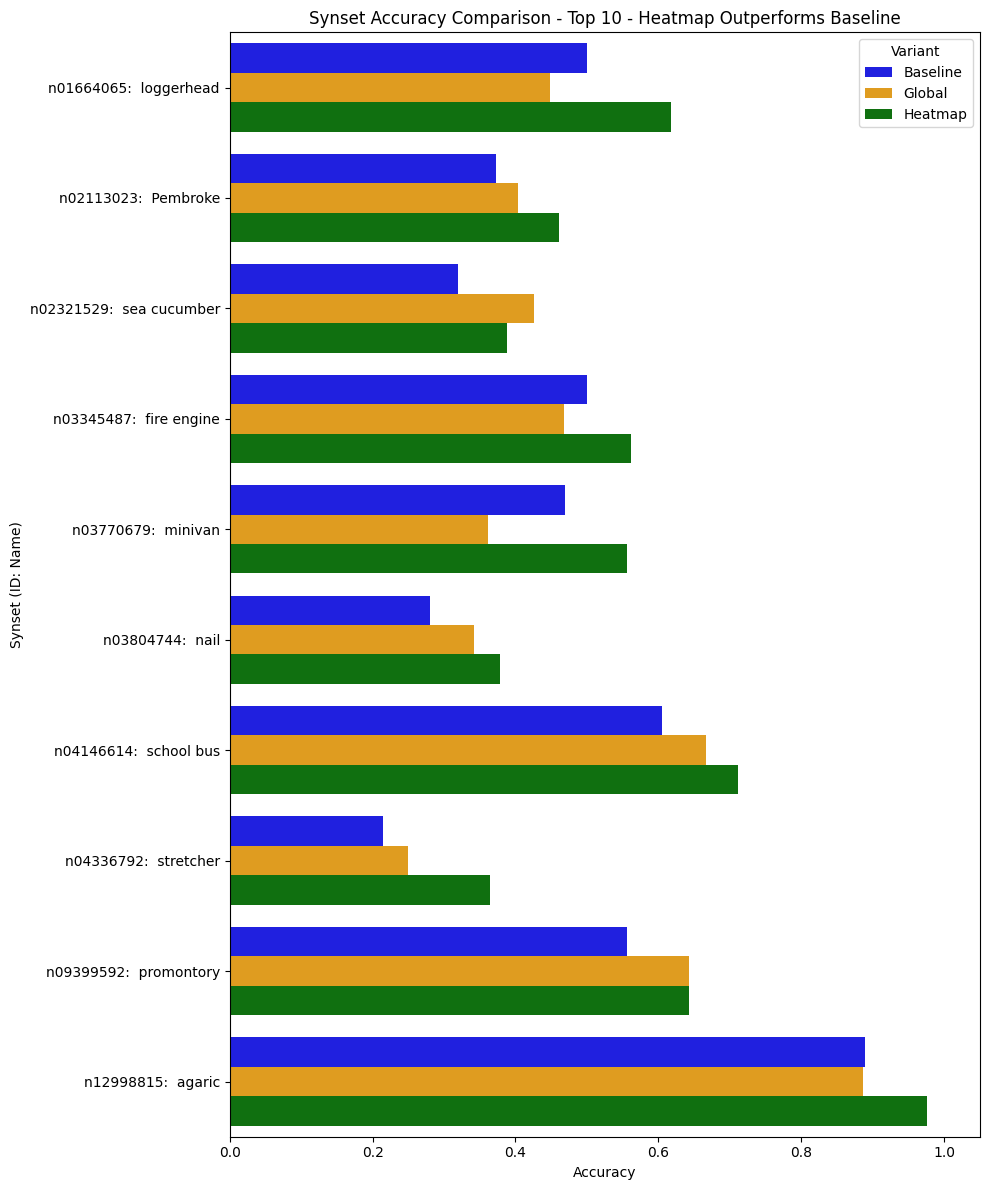


Top 10 synsets where Baseline performed significantly better than Heatmap:
           Baseline    Global   Heatmap  Heatmap_minus_Baseline
synset                                                         
n02815834  0.379310  0.090909  0.090909               -0.288401
n02102480  0.730769  0.542857  0.472222               -0.258547
n03538406  0.515625  0.400000  0.270588               -0.245037
n04532670  0.629630  0.433962  0.411765               -0.217865
n02835271  0.571429  0.538462  0.359375               -0.212054
n02116738  0.787234  0.587302  0.576271               -0.210963
n04479046  0.431818  0.400000  0.222222               -0.209596
n03388549  0.562500  0.388060  0.352941               -0.209559
n09193705  0.723404  0.525424  0.517857               -0.205547
n04099969  0.423077  0.312500  0.220339               -0.202738


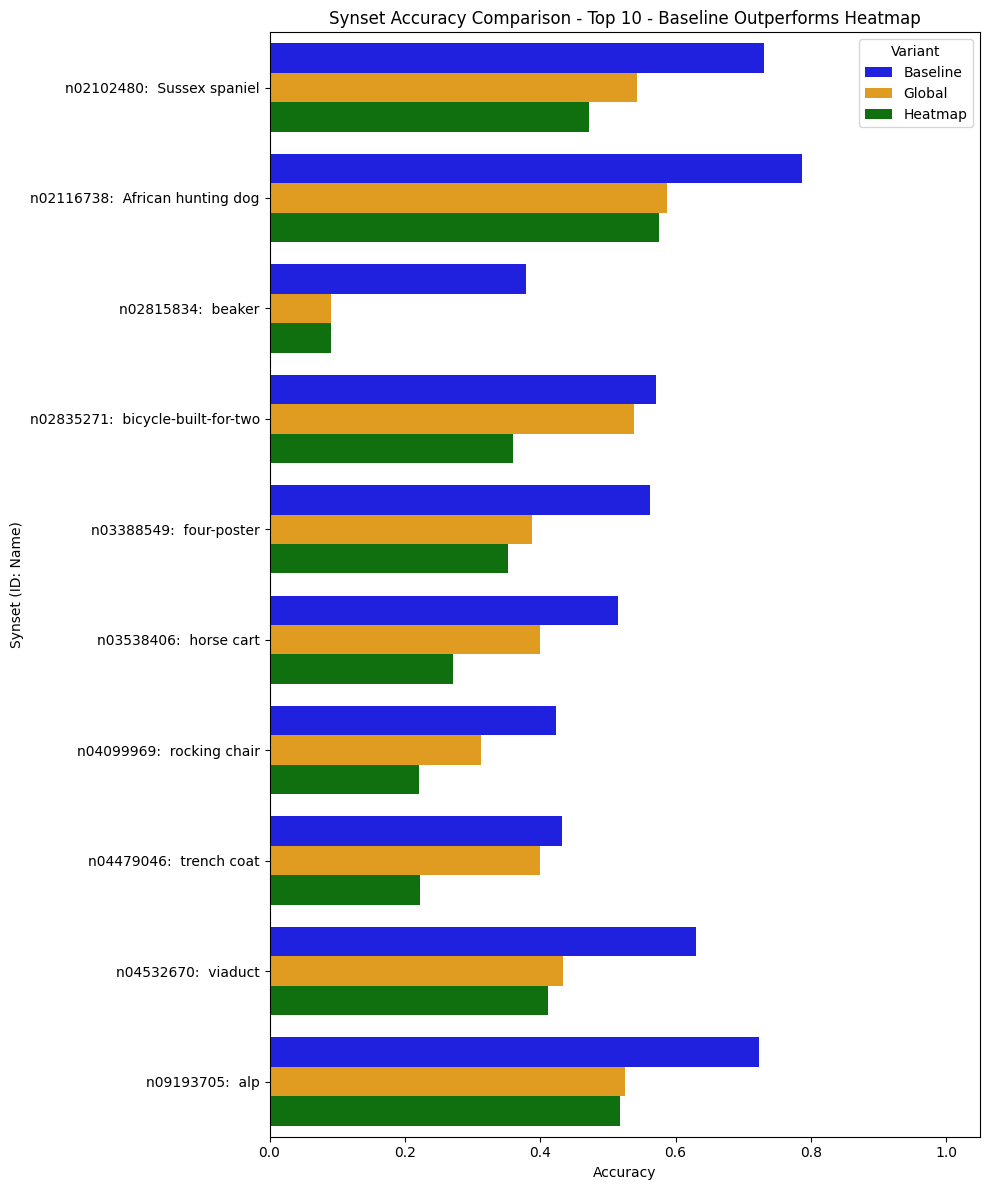

In [6]:
# New cell for focused comparisons against Baseline

# Number of top synsets to display for each comparison
k_top_comparison = 10 # You can adjust this number

# --- 1. Global vs. Baseline Comparison ---
all_accuracies_merged['Global_minus_Baseline'] = all_accuracies_merged['Global'] - all_accuracies_merged['Baseline']

# Synsets where Global performed MUCH BETTER than Baseline
global_better_than_baseline_synsets = all_accuracies_merged.sort_values(by='Global_minus_Baseline', ascending=False).head(k_top_comparison).index.tolist()
if global_better_than_baseline_synsets:
    print(f"\nTop {k_top_comparison} synsets where Global performed significantly better than Baseline:")
    print(all_accuracies_merged.loc[global_better_than_baseline_synsets, ['Baseline', 'Global', 'Heatmap', 'Global_minus_Baseline']])
    plot_accuracies_subplot(base_accuracy, global_accuracy, heatmap_accuracy, global_better_than_baseline_synsets, f"Top {k_top_comparison} - Global Outperforms Baseline")
else:
    print(f"\nNo synsets found where Global clearly outperforms Baseline by a significant margin for top {k_top_comparison}.")

# Synsets where Baseline performed MUCH BETTER than Global (i.e., Global_minus_Baseline is most negative)
baseline_better_than_global_synsets = all_accuracies_merged.sort_values(by='Global_minus_Baseline', ascending=True).head(k_top_comparison).index.tolist()
if baseline_better_than_global_synsets:
    print(f"\nTop {k_top_comparison} synsets where Baseline performed significantly better than Global:")
    print(all_accuracies_merged.loc[baseline_better_than_global_synsets, ['Baseline', 'Global', 'Heatmap', 'Global_minus_Baseline']])
    plot_accuracies_subplot(base_accuracy, global_accuracy, heatmap_accuracy, baseline_better_than_global_synsets, f"Top {k_top_comparison} - Baseline Outperforms Global")
else:
    print(f"\nNo synsets found where Baseline clearly outperforms Global by a significant margin for top {k_top_comparison}.")


# --- 2. Heatmap vs. Baseline Comparison ---
all_accuracies_merged['Heatmap_minus_Baseline'] = all_accuracies_merged['Heatmap'] - all_accuracies_merged['Baseline']

# Synsets where Heatmap performed MUCH BETTER than Baseline
heatmap_better_than_baseline_synsets = all_accuracies_merged.sort_values(by='Heatmap_minus_Baseline', ascending=False).head(k_top_comparison).index.tolist()
if heatmap_better_than_baseline_synsets:
    print(f"\nTop {k_top_comparison} synsets where Heatmap performed significantly better than Baseline:")
    print(all_accuracies_merged.loc[heatmap_better_than_baseline_synsets, ['Baseline', 'Global', 'Heatmap', 'Heatmap_minus_Baseline']])
    plot_accuracies_subplot(base_accuracy, global_accuracy, heatmap_accuracy, heatmap_better_than_baseline_synsets, f"Top {k_top_comparison} - Heatmap Outperforms Baseline")
else:
    print(f"\nNo synsets found where Heatmap clearly outperforms Baseline by a significant margin for top {k_top_comparison}.")

# Synsets where Baseline performed MUCH BETTER than Heatmap (i.e., Heatmap_minus_Baseline is most negative)
baseline_better_than_heatmap_synsets = all_accuracies_merged.sort_values(by='Heatmap_minus_Baseline', ascending=True).head(k_top_comparison).index.tolist()
if baseline_better_than_heatmap_synsets:
    print(f"\nTop {k_top_comparison} synsets where Baseline performed significantly better than Heatmap:")
    print(all_accuracies_merged.loc[baseline_better_than_heatmap_synsets, ['Baseline', 'Global', 'Heatmap', 'Heatmap_minus_Baseline']])
    plot_accuracies_subplot(base_accuracy, global_accuracy, heatmap_accuracy, baseline_better_than_heatmap_synsets, f"Top {k_top_comparison} - Baseline Outperforms Heatmap")
else:
    print(f"\nNo synsets found where Baseline clearly outperforms Heatmap by a significant margin for top {k_top_comparison}.")


Top 10 (out of 94 total) synsets where Baseline outperforms both Global and Heatmap by at least 5% (sorted by Baseline_Advantage):
           Baseline    Global   Heatmap  Baseline_Advantage
synset                                                     
n02815834  0.379310  0.090909  0.090909            0.288401
n02974003  0.777778  0.540541  0.575758            0.202020
n02116738  0.787234  0.587302  0.576271            0.199932
n09193705  0.723404  0.525424  0.517857            0.197981
n04532670  0.629630  0.433962  0.411765            0.195667
n02102480  0.730769  0.542857  0.472222            0.187912
n02443114  0.685714  0.387755  0.500000            0.185714
n06794110  0.625000  0.411765  0.444444            0.180556
n03388549  0.562500  0.388060  0.352941            0.174440
n04389033  0.536585  0.363636  0.352941            0.172949


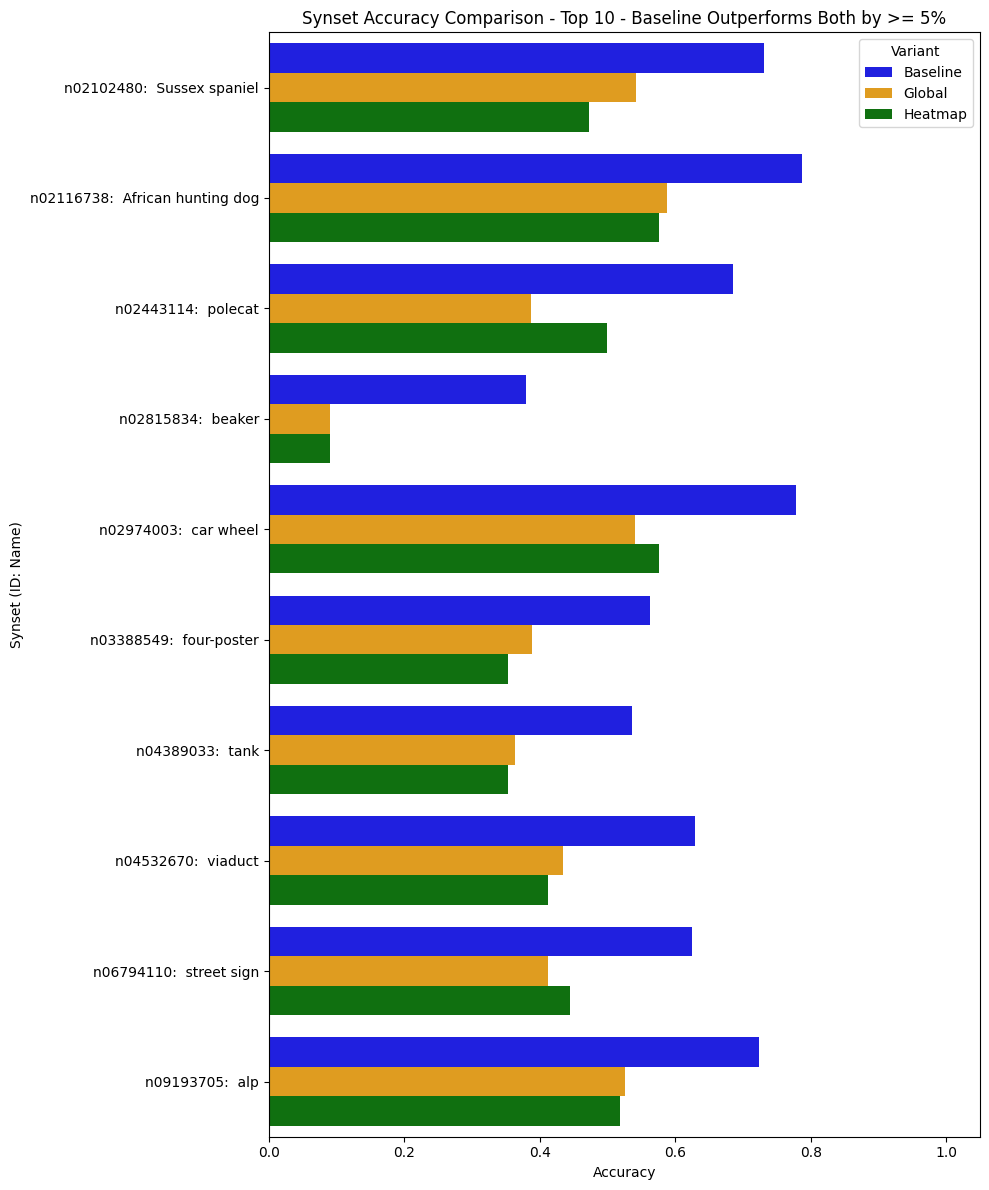


Top 10 (out of 17 total) synsets where Global outperforms both Baseline and Heatmap by at least 5% (sorted by Global_Advantage):
           Baseline    Global   Heatmap  Global_Advantage
synset                                                   
n02093647  0.548387  0.666667  0.466667          0.118280
n11879895  0.849057  0.959184  0.833333          0.110127
n12267677  0.607143  0.714286  0.600000          0.107143
n02108551  0.606557  0.703704  0.578947          0.097146
n01978287  0.380952  0.480000  0.382979          0.097021
n02640242  0.478261  0.575000  0.461538          0.096739
n04090263  0.239130  0.333333  0.190476          0.094203
n02011460  0.596154  0.688889  0.449275          0.092735
n03425413  0.333333  0.423729  0.295775          0.090395
n02120505  0.510204  0.600000  0.440000          0.089796


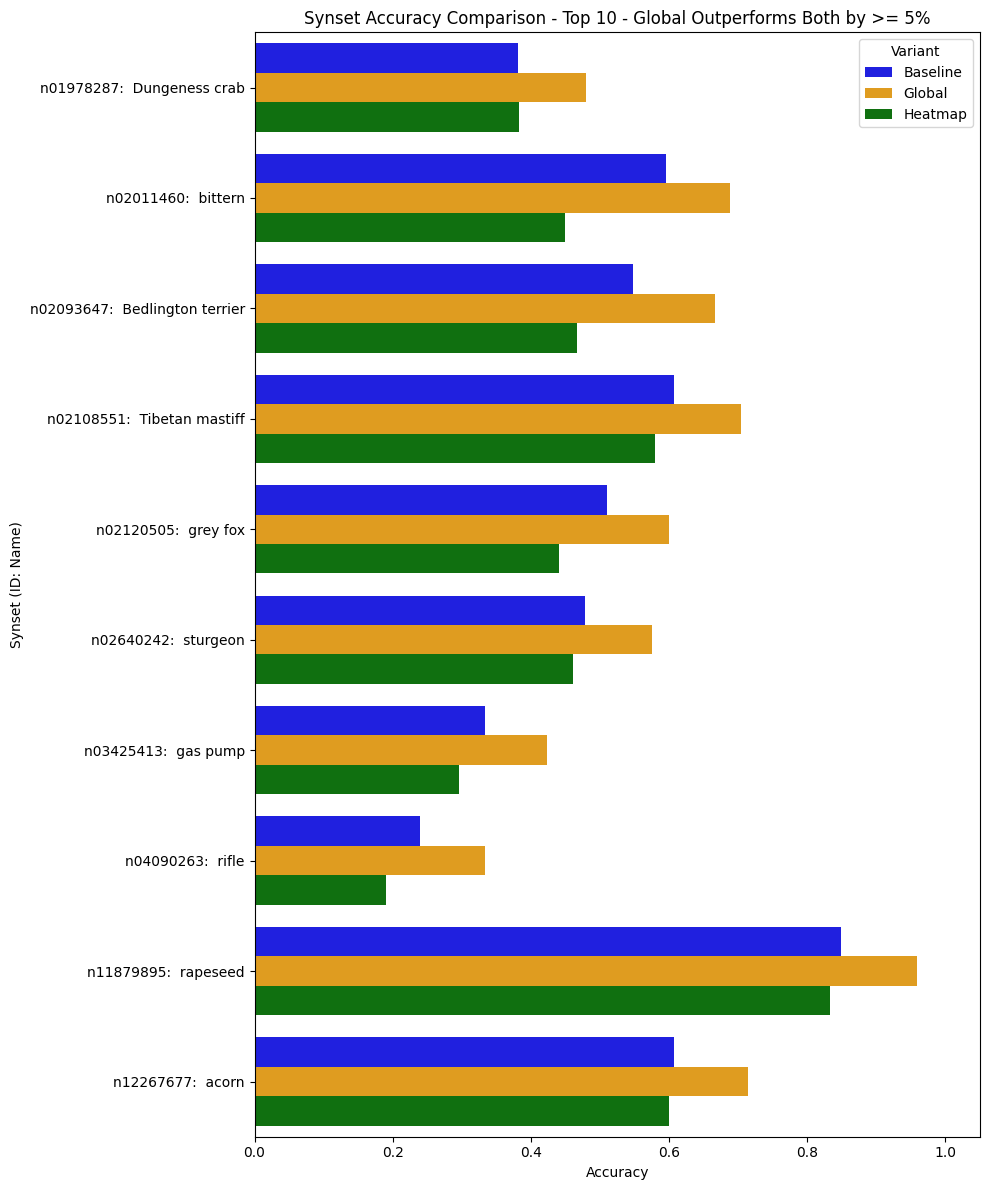


Top 6 (out of 6 total) synsets where Heatmap outperforms both Baseline and Global by at least 5% (sorted by Heatmap_Advantage):
           Baseline    Global   Heatmap  Heatmap_Advantage
synset                                                    
n01664065  0.500000  0.448276  0.617647           0.117647
n04336792  0.214286  0.250000  0.363636           0.113636
n12998815  0.888889  0.886364  0.976190           0.087302
n03770679  0.468750  0.361702  0.555556           0.086806
n03345487  0.500000  0.467742  0.561404           0.061404
n02113023  0.373134  0.403509  0.461538           0.058030


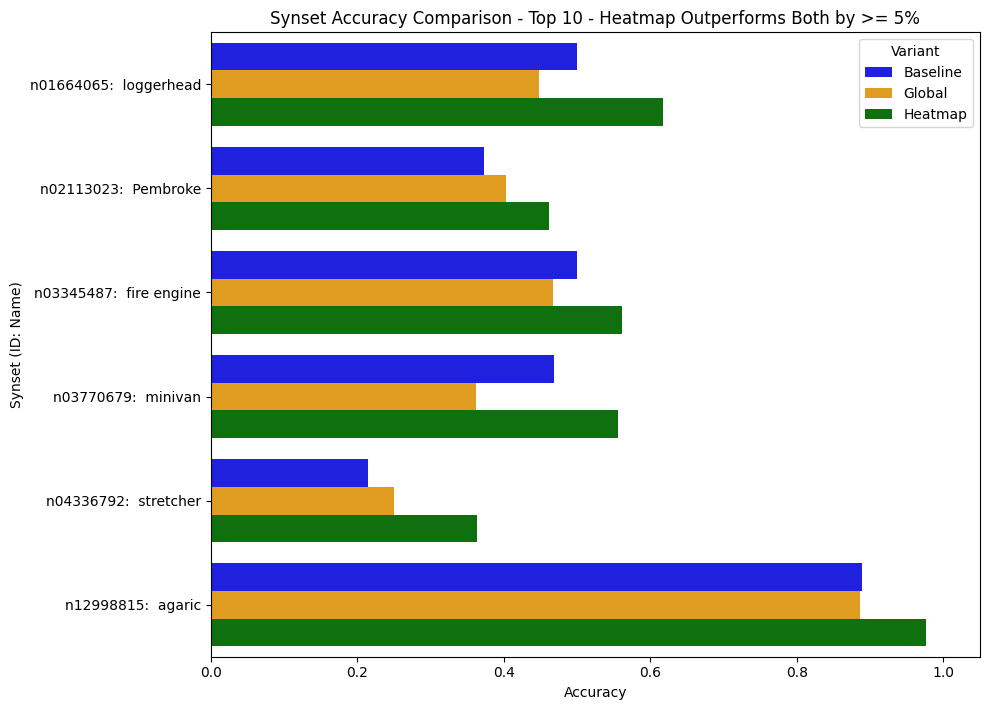


Top 5 (out of 5 total) synsets where Global and Heatmap are SIMILAR (<5%) and BOTH OUTPERFORM Baseline by at least 5%:
           Baseline    Global   Heatmap  GH_Similarity_Diff  \
synset                                                        
n02321529  0.318841  0.425926  0.387755            0.038171   
n09399592  0.555556  0.642857  0.642857            0.000000   
n04146614  0.605634  0.666667  0.711538            0.044872   
n03804744  0.280000  0.341463  0.377778            0.036314   
n07753275  0.690476  0.787879  0.743590            0.044289   

           GH_Avg_vs_Baseline  
synset                         
n02321529            0.088000  
n09399592            0.087302  
n04146614            0.083469  
n03804744            0.079621  
n07753275            0.075258  


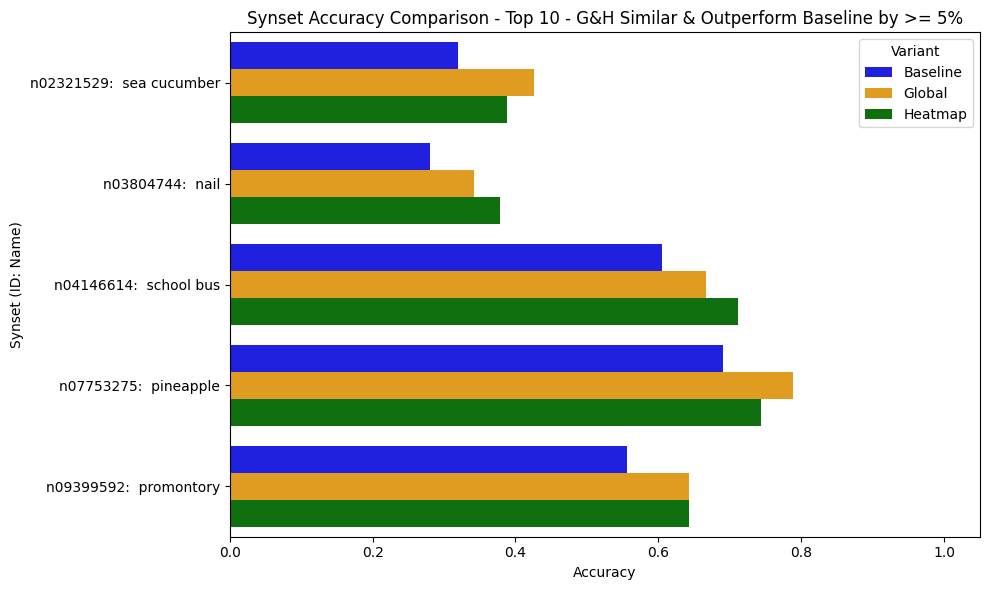


Top 10 (out of 64 total) synsets where Global and Heatmap are SIMILAR (<5%) and BOTH UNDERPERFORM Baseline (Baseline is at least 5% better):
           Baseline    Global   Heatmap  GH_Similarity_Diff  \
synset                                                        
n02815834  0.379310  0.090909  0.090909            0.000000   
n02974003  0.777778  0.540541  0.575758            0.035217   
n04532670  0.629630  0.433962  0.411765            0.022198   
n02116738  0.787234  0.587302  0.576271            0.011030   
n09193705  0.723404  0.525424  0.517857            0.007567   
n06794110  0.625000  0.411765  0.444444            0.032680   
n03388549  0.562500  0.388060  0.352941            0.035119   
n13133613  0.634146  0.446154  0.465517            0.019363   
n04389033  0.536585  0.363636  0.352941            0.010695   
n03661043  0.500000  0.333333  0.328125            0.005208   

           Baseline_vs_GH_Avg  
synset                         
n02815834            0.288401  
n0297

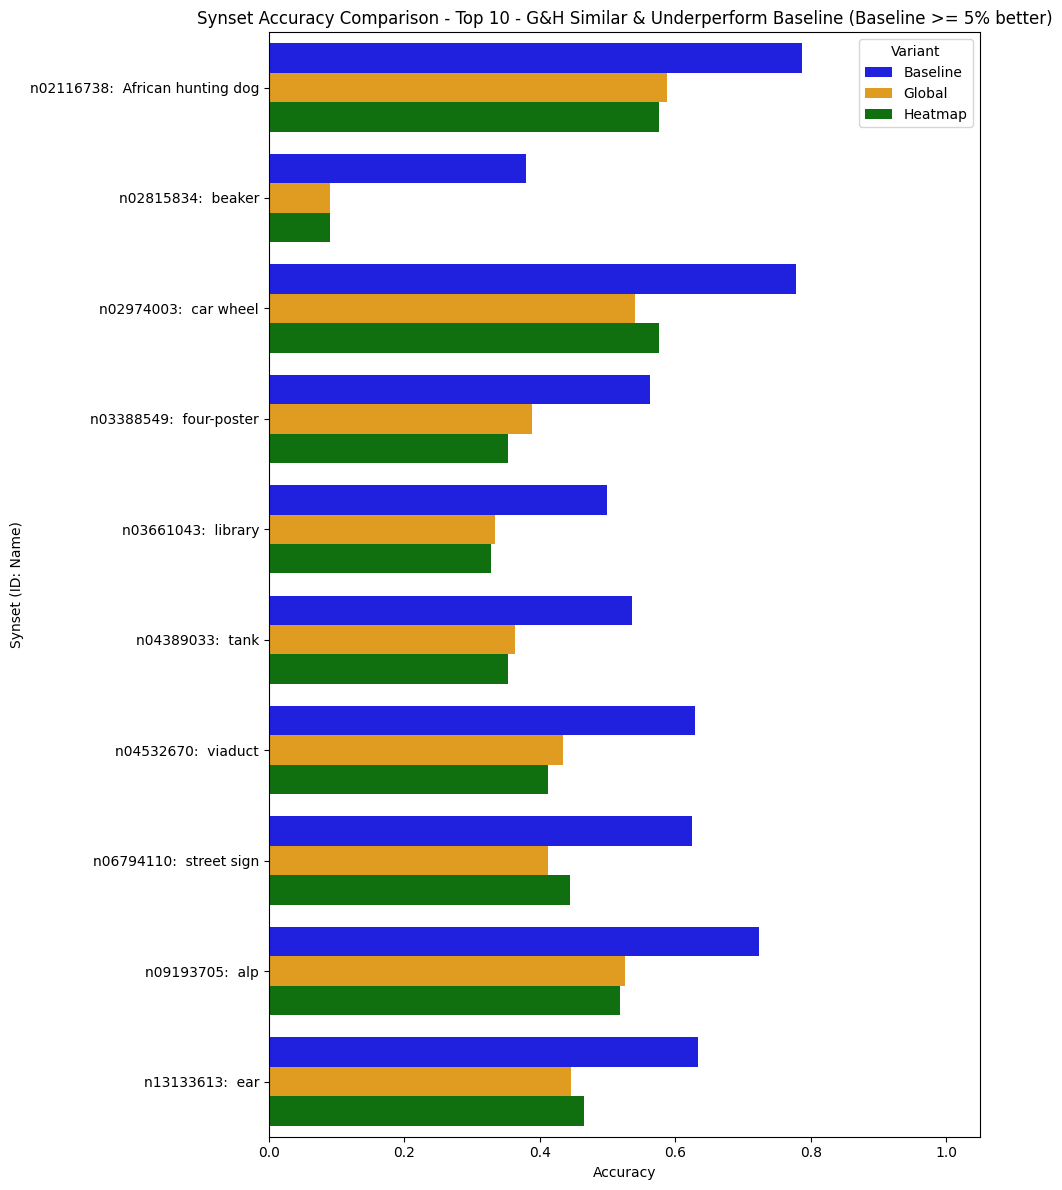

In [7]:
# k_top_excel is assumed to be defined in your environment (e.g., k_top_excel = 10 from the variable list).
# If k_top_excel is not defined, you might need to set it, e.g.:
k_top_excel = 10
similarity_threshold = 0.05 # Define how close "similar" means AND the outperformance margin

# Calculate the advantage columns (how much each model outperforms the others)
all_accuracies_merged['Baseline_Advantage'] = all_accuracies_merged['Baseline'] - all_accuracies_merged[['Global', 'Heatmap']].max(axis=1)
all_accuracies_merged['Global_Advantage'] = all_accuracies_merged['Global'] - all_accuracies_merged[['Baseline', 'Heatmap']].max(axis=1)
all_accuracies_merged['Heatmap_Advantage'] = all_accuracies_merged['Heatmap'] - all_accuracies_merged[['Baseline', 'Global']].max(axis=1)

# --- 1. Baseline outperforms both Global and Heatmap by at least 5% ---
# We use the 'Baseline_Advantage' column: Baseline - max(Global, Heatmap)
# Positive values >= similarity_threshold mean Baseline is at least 5% better than both.
baseline_excels_df = all_accuracies_merged[all_accuracies_merged['Baseline_Advantage'] >= similarity_threshold].sort_values(by='Baseline_Advantage', ascending=False)
baseline_excels_synsets_list = baseline_excels_df.head(k_top_excel).index.tolist()

if baseline_excels_synsets_list:
    print(f"\nTop {len(baseline_excels_synsets_list)} (out of {len(baseline_excels_df)} total) synsets where Baseline outperforms both Global and Heatmap by at least {similarity_threshold*100:.0f}% (sorted by Baseline_Advantage):")
    print(all_accuracies_merged.loc[baseline_excels_synsets_list, ['Baseline', 'Global', 'Heatmap', 'Baseline_Advantage']])
    plot_accuracies_subplot(base_accuracy, global_accuracy, heatmap_accuracy, baseline_excels_synsets_list, f"Top {k_top_excel} - Baseline Outperforms Both by >= {similarity_threshold*100:.0f}%")
else:
    print(f"\nNo synsets to display for top {k_top_excel} where Baseline outperforms both Global and Heatmap by at least {similarity_threshold*100:.0f}% (total found: {len(baseline_excels_df)}).")

# --- 2. Global outperforms both Baseline and Heatmap by at least 5% ---
# We use the 'Global_Advantage' column: Global - max(Baseline, Heatmap)
global_excels_df = all_accuracies_merged[all_accuracies_merged['Global_Advantage'] >= similarity_threshold].sort_values(by='Global_Advantage', ascending=False)
global_excels_synsets_list = global_excels_df.head(k_top_excel).index.tolist()

if global_excels_synsets_list:
    print(f"\nTop {len(global_excels_synsets_list)} (out of {len(global_excels_df)} total) synsets where Global outperforms both Baseline and Heatmap by at least {similarity_threshold*100:.0f}% (sorted by Global_Advantage):")
    print(all_accuracies_merged.loc[global_excels_synsets_list, ['Baseline', 'Global', 'Heatmap', 'Global_Advantage']])
    plot_accuracies_subplot(base_accuracy, global_accuracy, heatmap_accuracy, global_excels_synsets_list, f"Top {k_top_excel} - Global Outperforms Both by >= {similarity_threshold*100:.0f}%")
else:
    print(f"\nNo synsets to display for top {k_top_excel} where Global outperforms both Baseline and Heatmap by at least {similarity_threshold*100:.0f}% (total found: {len(global_excels_df)}).")

# --- 3. Heatmap outperforms both Baseline and Global by at least 5% ---
# We use the 'Heatmap_Advantage' column: Heatmap - max(Baseline, Global)
heatmap_excels_df = all_accuracies_merged[all_accuracies_merged['Heatmap_Advantage'] >= similarity_threshold].sort_values(by='Heatmap_Advantage', ascending=False)
heatmap_excels_synsets_list = heatmap_excels_df.head(k_top_excel).index.tolist()

if heatmap_excels_synsets_list:
    print(f"\nTop {len(heatmap_excels_synsets_list)} (out of {len(heatmap_excels_df)} total) synsets where Heatmap outperforms both Baseline and Global by at least {similarity_threshold*100:.0f}% (sorted by Heatmap_Advantage):")
    print(all_accuracies_merged.loc[heatmap_excels_synsets_list, ['Baseline', 'Global', 'Heatmap', 'Heatmap_Advantage']])
    plot_accuracies_subplot(base_accuracy, global_accuracy, heatmap_accuracy, heatmap_excels_synsets_list, f"Top {k_top_excel} - Heatmap Outperforms Both by >= {similarity_threshold*100:.0f}%")
else:
    print(f"\nNo synsets to display for top {k_top_excel} where Heatmap outperforms both Baseline and Global by at least {similarity_threshold*100:.0f}% (total found: {len(heatmap_excels_df)}).")

# --- Similarity Comparisons for Global and Heatmap ---
# similarity_threshold = 0.05 # Defined above

# Create a temporary DataFrame for these specific comparisons by copying to avoid modifying the original
temp_df_gh_similar = all_accuracies_merged.copy()
temp_df_gh_similar['GH_Similarity_Diff'] = abs(temp_df_gh_similar['Global'] - temp_df_gh_similar['Heatmap'])

# --- 4. Global and Heatmap similar, AND they OUTPERFORM Baseline by at least 5% ---
# Filter for synsets meeting the criteria
gh_similar_outperform_b_df = temp_df_gh_similar[
    (temp_df_gh_similar['GH_Similarity_Diff'] < similarity_threshold) &
    ((temp_df_gh_similar['Global'] - temp_df_gh_similar['Baseline']) >= similarity_threshold) &
    ((temp_df_gh_similar['Heatmap'] - temp_df_gh_similar['Baseline']) >= similarity_threshold)
].copy() # Use .copy() to ensure it's a new DataFrame

if not gh_similar_outperform_b_df.empty:
    # Calculate how much they outperform Baseline on average
    gh_similar_outperform_b_df['GH_Avg_vs_Baseline'] = \
        (gh_similar_outperform_b_df['Global'] + gh_similar_outperform_b_df['Heatmap']) / 2 - gh_similar_outperform_b_df['Baseline']
    
    gh_similar_outperform_b_df = gh_similar_outperform_b_df.sort_values(by='GH_Avg_vs_Baseline', ascending=False)
    gh_similar_outperform_b_synsets = gh_similar_outperform_b_df.head(k_top_excel).index.tolist()

    if gh_similar_outperform_b_synsets:
        print(f"\nTop {len(gh_similar_outperform_b_synsets)} (out of {len(gh_similar_outperform_b_df)} total) synsets where Global and Heatmap are SIMILAR (<{similarity_threshold*100:.0f}%) and BOTH OUTPERFORM Baseline by at least {similarity_threshold*100:.0f}%:")
        print(gh_similar_outperform_b_df.loc[gh_similar_outperform_b_synsets, ['Baseline', 'Global', 'Heatmap', 'GH_Similarity_Diff', 'GH_Avg_vs_Baseline']])
        plot_accuracies_subplot(base_accuracy, global_accuracy, heatmap_accuracy, gh_similar_outperform_b_synsets, f"Top {k_top_excel} - G&H Similar & Outperform Baseline by >= {similarity_threshold*100:.0f}%")
    else:
        print(f"\nNo synsets to display for top {k_top_excel} where Global and Heatmap are SIMILAR (<{similarity_threshold*100:.0f}%) and BOTH OUTPERFORM Baseline by at least {similarity_threshold*100:.0f}% (total found: {len(gh_similar_outperform_b_df)}).")
else:
    print(f"\nNo synsets found where Global and Heatmap are SIMILAR (<{similarity_threshold*100:.0f}%) and BOTH OUTPERFORM Baseline by at least {similarity_threshold*100:.0f}% (total found: 0).")


# --- 5. Global and Heatmap similar, AND they UNDERPERFORM Baseline (Baseline is at least 5% better) ---
# Filter for synsets meeting the criteria
gh_similar_underperform_b_df = temp_df_gh_similar[
    (temp_df_gh_similar['GH_Similarity_Diff'] < similarity_threshold) &
    ((temp_df_gh_similar['Baseline'] - temp_df_gh_similar['Global']) >= similarity_threshold) &
    ((temp_df_gh_similar['Baseline'] - temp_df_gh_similar['Heatmap']) >= similarity_threshold)
].copy() # Use .copy() to ensure it's a new DataFrame

if not gh_similar_underperform_b_df.empty:
    # Calculate how much Baseline outperforms their average
    gh_similar_underperform_b_df['Baseline_vs_GH_Avg'] = \
        gh_similar_underperform_b_df['Baseline'] - (gh_similar_underperform_b_df['Global'] + gh_similar_underperform_b_df['Heatmap']) / 2
        
    gh_similar_underperform_b_df = gh_similar_underperform_b_df.sort_values(by='Baseline_vs_GH_Avg', ascending=False)
    gh_similar_underperform_b_synsets = gh_similar_underperform_b_df.head(k_top_excel).index.tolist()

    if gh_similar_underperform_b_synsets:
        print(f"\nTop {len(gh_similar_underperform_b_synsets)} (out of {len(gh_similar_underperform_b_df)} total) synsets where Global and Heatmap are SIMILAR (<{similarity_threshold*100:.0f}%) and BOTH UNDERPERFORM Baseline (Baseline is at least {similarity_threshold*100:.0f}% better):")
        print(gh_similar_underperform_b_df.loc[gh_similar_underperform_b_synsets, ['Baseline', 'Global', 'Heatmap', 'GH_Similarity_Diff', 'Baseline_vs_GH_Avg']])
        plot_accuracies_subplot(base_accuracy, global_accuracy, heatmap_accuracy, gh_similar_underperform_b_synsets, f"Top {k_top_excel} - G&H Similar & Underperform Baseline (Baseline >= {similarity_threshold*100:.0f}% better)")
    else:
        print(f"\nNo synsets to display for top {k_top_excel} where Global and Heatmap are SIMILAR (<{similarity_threshold*100:.0f}%) and BOTH UNDERPERFORM Baseline (Baseline at least {similarity_threshold*100:.0f}% better) (total found: {len(gh_similar_underperform_b_df)}).")
else:
    print(f"\nNo synsets found where Global and Heatmap are SIMILAR (<{similarity_threshold*100:.0f}%) and BOTH UNDERPERFORM Baseline (Baseline at least {similarity_threshold*100:.0f}% better) (total found: 0).")


In [ ]:
import os
from PIL import Image
from IPython.display import display, HTML
import random
import io
import base64

# Create helper function to get name from synset ID
def get_name_from_synset(synset_id):
    return synset_to_name.get(synset_id, "Unknown")

# Function to get misclassified images with detailed info
def get_misclassifications(df, model_name):
    misclassified = df[df['correct'] == 0].copy()
    
    # Map prediction and target to synset IDs
    misclassified['pred_synset'] = misclassified['prediction'].map(id_to_synset)
    misclassified['true_synset'] = misclassified['target'].map(id_to_synset)
    
    # Map synsets to human-readable names
    misclassified['pred_name'] = misclassified['pred_synset'].map(get_name_from_synset)
    misclassified['true_name'] = misclassified['true_synset'].map(get_name_from_synset)
    
    # Get absolute index in original dataset
    misclassified['img_index'] = misclassified['index']
    
    # Add model name for later merging
    misclassified['model'] = model_name
    
    return misclassified[['img_index', 'model', 'true_synset', 'true_name', 'pred_synset', 'pred_name']]

# Get misclassifications for each model
base_misclass = get_misclassifications(base_df, "Baseline")
global_misclass = get_misclassifications(global_df, "Global")
heatmap_misclass = get_misclassifications(heatmap_df, "Heatmap")

# Combine all misclassifications
all_misclass = pd.concat([base_misclass, global_misclass, heatmap_misclass])

# Function to find image path based on synset ID
def find_image_path(index, true_synset):
    # Look through the validation directory for this synset
    synset_dir = os.path.join(val_dir, true_synset)
    
    # If directory exists, find images
    if os.path.exists(synset_dir):
        # Get all images in this synset directory
        images = [f for f in os.listdir(synset_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        # In ImageNet, images often follow naming pattern like n01440764_2708.JPEG
        # If we can't directly map index to filename, use deterministic choice
        # This is a simplification - you may need to adjust based on your actual filename pattern
        if len(images) > index % len(images):
            return os.path.join(synset_dir, images[index % len(images)])
    return None

# Function to show misclassifications where true and predicted classes are very different
def find_unexpected_misclassifications(df=None, n=10):
    """
    Find misclassifications where the true and predicted classes are semantically very different
    
    Args:
        df: DataFrame with misclassifications. If None, use all_misclass
        n: Number of examples to show
    """
    if df is None:
        df = all_misclass
    
    # This is where you would implement logic to determine which misclassifications are surprising
    # For now, let's just sample random misclassifications
    # In practice, you might want to use a semantic similarity measure between classes
    
    # For demonstration, let's just show random samples
    samples = df.sample(min(n, len(df)))
    
    return samples

# Function to display misclassified images in a grid
def display_misclassified_images(misclass_df, max_images=9):
    """
    Display a grid of misclassified images with their true and predicted labels
    """
    n_images = min(len(misclass_df), max_images)
    if n_images == 0:
        print("No misclassifications to display")
        return
    
    # Create HTML for grid display
    html = "<div style='display: flex; flex-wrap: wrap;'>"
    
    for i, row in misclass_df.head(n_images).iterrows():
        # Find image path
        img_path = find_image_path(row['img_index'], row['true_synset'])
        
        # Extract just the filename for display
        img_filename = os.path.basename(img_path) if img_path else "Unknown"
        
        if img_path and os.path.exists(img_path):
            try:
                # Load and resize image
                img = Image.open(img_path)
                img.thumbnail((224, 224))
                
                # Convert to data URL
                buffer = io.BytesIO()
                img.save(buffer, format='JPEG')
                img_str = base64.b64encode(buffer.getvalue()).decode('utf-8')
                
                # Add to HTML with filename included
                html += f"""
                <div style='margin: 10px; text-align: center;'>
                    <img src='data:image/jpeg;base64,{img_str}' style='width:200px; height:auto;'>
                    <p>Index: {row['img_index']}<br>
                    <b>File: {img_filename}</b><br>
                    True: {row['true_name']}<br>
                    Pred: {row['pred_name']}<br>
                    Model: {row['model']}</p>
                </div>
                """
            except Exception as e:
                print(f"Error displaying image {img_path}: {e}")
        else:
            html += f"""
            <div style='margin: 10px; text-align: center; width:200px;'>
                <div style='width:200px; height:200px; background:#eee; display:flex; align-items:center; justify-content:center;'>
                    Image not found
                </div>
                <p>Index: {row['img_index']}<br>
                <b>File: {img_filename}</b><br>
                True: {row['true_name']}<br>
                Pred: {row['pred_name']}<br>
                Model: {row['model']}</p>
            </div>
            """
    
    html += "</div>"
    display(HTML(html))

# Example usage: Display some unexpected misclassifications
print(f"Total misclassifications: {len(all_misclass)}")
print(f"Baseline misclassifications: {len(base_misclass)}")
print(f"Global misclassifications: {len(global_misclass)}")
print(f"Heatmap misclassifications: {len(heatmap_misclass)}")

# Find classes with the most different predictions (where model predictions are out of line)
# For a simple implementation, let's filter cases where a dog might be classified as a boat, etc.

# Interactive function to select and display images 
def interactive_misclass_explorer(random_seed=None):
    if random_seed is not None:
        random.seed(random_seed)
    
    # 1. Filter by model
    model_options = ['All'] + list(all_misclass['model'].unique())
    selected_model = input(f"Enter model to analyze {model_options} (default: All): ") or 'All'
    
    filtered_df = all_misclass if selected_model == 'All' else all_misclass[all_misclass['model'] == selected_model]
    
    # 2. Choose filtering method
    print("\nFilter options:")
    print("1. Random samples")
    print("2. Filter by true class")
    print("3. Filter by predicted class")
    print("4. Show extreme mismatches (heuristic)")
    
    filter_option = input("Choose filter option (default: 1): ") or '1'
    
    if filter_option == '1':
        # Random samples
        n_samples = int(input("Number of random samples to show (default: 6): ") or 6)
        result_df = filtered_df.sample(min(n_samples, len(filtered_df)))
    
    elif filter_option == '2':
        # Filter by true class
        true_classes = sorted(filtered_df['true_name'].unique().tolist())
        print("Available true classes:")
        for i, cls in enumerate(true_classes):
            print(f"{i+1}. {cls}")
        
        selection = input("Enter number(s) of class(es) to include (comma-separated): ")
        if not selection.strip():
            selected_classes = true_classes
        else:
            selected_indices = [int(x.strip())-1 for x in selection.split(',')]
            selected_classes = [true_classes[i] for i in selected_indices if 0 <= i < len(true_classes)]
        
        result_df = filtered_df[filtered_df['true_name'].isin(selected_classes)]
        n_samples = int(input(f"Found {len(result_df)} matches. How many to show? (default: all): ") or len(result_df))
        result_df = result_df.sample(min(n_samples, len(result_df)))
    
    elif filter_option == '3':
        # Filter by predicted class
        pred_classes = sorted(filtered_df['pred_name'].unique().tolist())
        print("Available predicted classes:")
        for i, cls in enumerate(pred_classes):
            print(f"{i+1}. {cls}")
        
        selection = input("Enter number(s) of class(es) to include (comma-separated): ")
        selected_indices = [int(x.strip())-1 for x in selection.split(',')]
        selected_classes = [pred_classes[i] for i in selected_indices if 0 <= i < len(pred_classes)]
        
        result_df = filtered_df[filtered_df['pred_name'].isin(selected_classes)]
        n_samples = int(input(f"Found {len(result_df)} matches. How many to show? (default: all): ") or len(result_df))
        result_df = result_df.sample(min(n_samples, len(result_df)))
    
    elif filter_option == '4':
        # Show extreme mismatches where true and predicted classes are very different
        # This is a simple heuristic - if true and pred have no common words, they're likely different
        
        def simple_similarity(row):
            # Simple word overlap between true and predicted names
            true_words = set(row['true_name'].lower().split())
            pred_words = set(row['pred_name'].lower().split())
            overlap = len(true_words.intersection(pred_words))
            return overlap
        
        filtered_df['similarity'] = filtered_df.apply(simple_similarity, axis=1)
        result_df = filtered_df[filtered_df['similarity'] == 0].sort_values('similarity')
        
        n_samples = int(input(f"Found {len(result_df)} extreme mismatches. How many to show? (default: 6): ") or 6)
        result_df = result_df.head(min(n_samples, len(result_df)))
    
    # Display results
    if len(result_df) > 0:
        display_misclassified_images(result_df)
    else:
        print("No matching images found with the given criteria.")
        
    return result_df

# Run the interactive explorer
# misclass_examples = interactive_misclass_explorer()

Total misclassifications: 15412
Baseline misclassifications: 4689
Global misclassifications: 5243
Heatmap misclassifications: 5480


In [17]:
def display_misclassified_images_with_heatmap(misclass_df, max_images=9):
    """
    Display a grid of clickable misclassified images that toggle heatmap overlays
    """
    n_images = min(len(misclass_df), max_images)
    if n_images == 0:
        print("No misclassifications to display")
        return
    
    # Define the base directories
    val_dir = r"C:\Users\joren\Documents\_Uni\Master\Thesis\val"
    heatmap_base_dir = r"C:\Users\joren\Documents\_Uni\Master\Thesis\val_heat"
    
    # Create a unique ID for this image gallery
    gallery_id = f"gallery_{random.randint(1000, 9999)}"
    
    # JavaScript for handling image clicks
    html = f"""
    <script>
        function toggleHeatmap(imgId, originalSrc, heatmapSrc) {{
            const img = document.getElementById(imgId);
            if (img.getAttribute('data-showing') === 'heatmap') {{
                img.src = originalSrc;
                img.setAttribute('data-showing', 'original');
            }} else {{
                img.src = heatmapSrc;
                img.setAttribute('data-showing', 'heatmap');
            }}
        }}
    </script>
    <div id="{gallery_id}" style="display: flex; flex-wrap: wrap;">
    """
    
    for i, row in misclass_df.head(n_images).iterrows():
        # Find image path
        img_path = find_image_path(row['img_index'], row['true_synset'])
        img_id = f"img_{gallery_id}_{i}"
        img_filename = os.path.basename(img_path) if img_path else "Unknown"
        
        # Find the corresponding heatmap path - same structure but in val_heat directory
        if img_path:
            # Get the relative path from val_dir
            rel_path = os.path.relpath(img_path, val_dir)
            # Construct the heatmap path by joining heatmap_base_dir with this relative path
            heatmap_path = os.path.join(heatmap_base_dir, rel_path)
        else:
            heatmap_path = None
            
        if img_path and os.path.exists(img_path):
            try:
                # Load and resize image
                img = Image.open(img_path)
                img.thumbnail((224, 224))
                
                # Convert to data URL
                buffer = io.BytesIO()
                img.save(buffer, format='JPEG')
                img_str = base64.b64encode(buffer.getvalue()).decode('utf-8')
                
                # Check if heatmap exists, prepare heatmap data URL
                heatmap_str = ""
                has_heatmap = False
                
                if heatmap_path and os.path.exists(heatmap_path):
                    try:
                        heatmap_img = Image.open(heatmap_path)
                        heatmap_img.thumbnail((224, 224))
                        
                        heatmap_buffer = io.BytesIO()
                        heatmap_img.save(heatmap_buffer, format='JPEG')
                        heatmap_str = base64.b64encode(heatmap_buffer.getvalue()).decode('utf-8')
                        has_heatmap = True
                    except Exception as e:
                        print(f"Error loading heatmap {heatmap_path}: {e}")
                
                # Add to HTML with clickable image
                if has_heatmap:
                    html += f"""
                    <div style='margin: 10px; text-align: center;'>
                        <img id="{img_id}" src='data:image/jpeg;base64,{img_str}' 
                             style='width:200px; height:auto; cursor:pointer;'
                             data-showing='original'
                             onclick="toggleHeatmap('{img_id}', 'data:image/jpeg;base64,{img_str}', 'data:image/jpeg;base64,{heatmap_str}')">
                        <p>Index: {row['img_index']}<br>
                        <b>File: {img_filename}</b><br>
                        True: {row['true_name']}<br>
                        Pred: {row['pred_name']}<br>
                        Model: {row['model']}<br>
                        </p>
                    </div>
                    """
                else:
                    html += f"""
                    <div style='margin: 10px; text-align: center;'>
                        <img src='data:image/jpeg;base64,{img_str}' style='width:200px; height:auto;'>
                        <p>Index: {row['img_index']}<br>
                        <b>File: {img_filename}</b><br>
                        True: {row['true_name']}<br>
                        Pred: {row['pred_name']}<br>
                        Model: {row['model']}<br>
                        <span style="color:gray;">No heatmap available</span></p>
                    </div>
                    """
            except Exception as e:
                print(f"Error displaying image {img_path}: {e}")
        else:
            html += f"""
            <div style='margin: 10px; text-align: center; width:200px;'>
                <div style='width:200px; height:200px; background:#eee; display:flex; align-items:center; justify-content:center;'>
                    Image not found
                </div>
                <p>Index: {row['img_index']}<br>
                <b>File: {img_filename}</b><br>
                True: {row['true_name']}<br>
                Pred: {row['pred_name']}<br>
                Model: {row['model']}</p>
            </div>
            """
    
    html += "</div>"
    display(HTML(html))

HTML(value='<h3>True Class 120/200:  mountain bike</h3><p>Found 23 misclassifications for this class with mode…


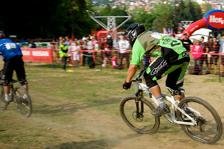
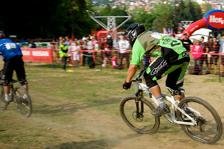
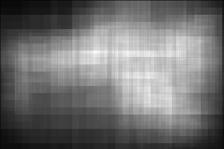
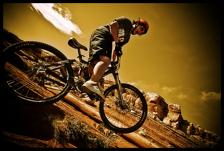
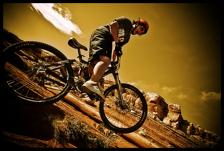
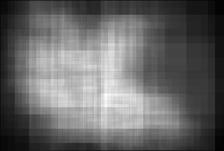
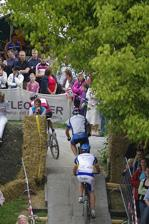
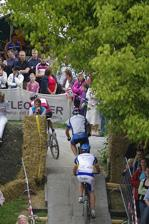
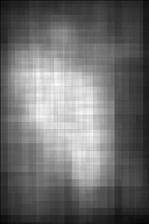
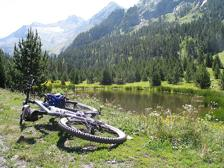
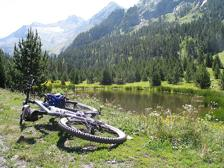
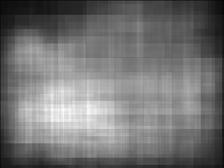
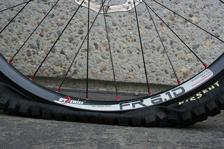
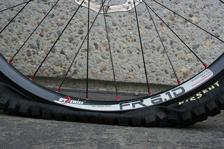
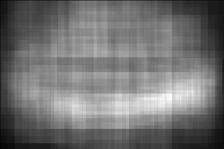
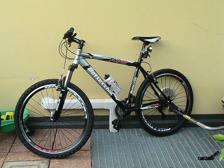
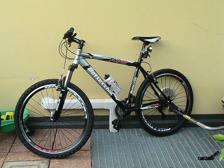
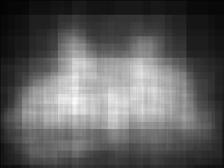
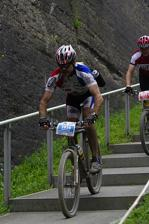
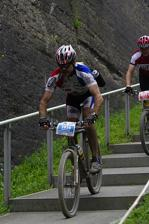
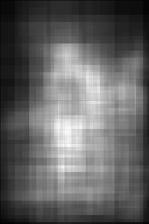
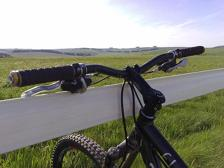
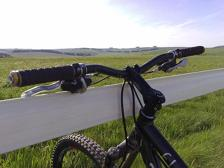
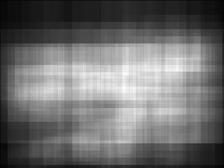
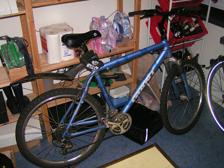
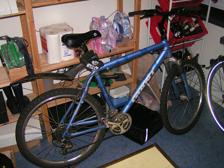
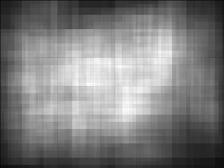
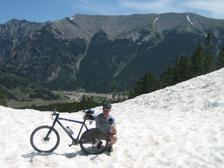
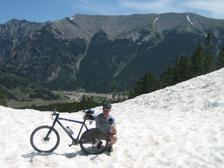
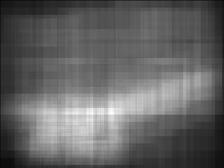
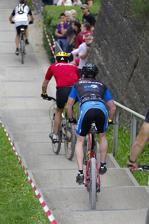
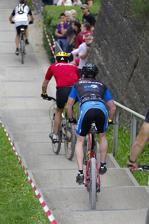
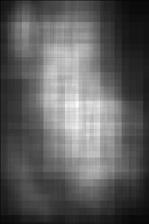
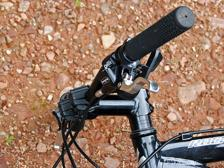
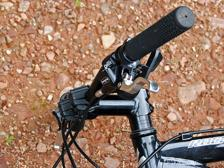
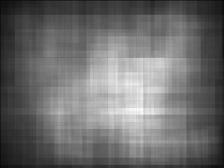
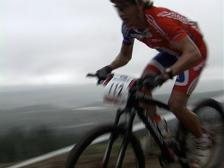
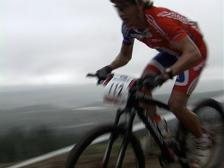
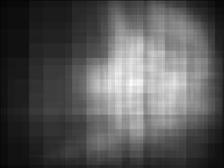
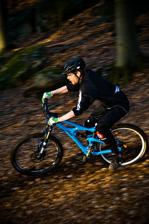
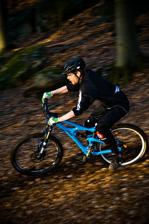
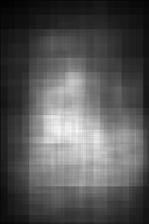
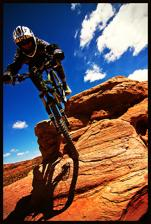
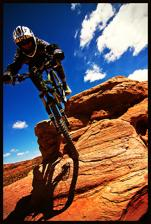
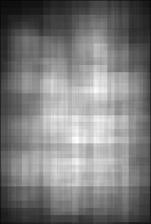
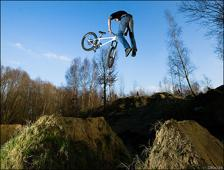
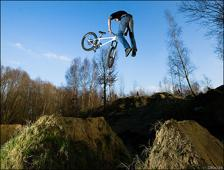
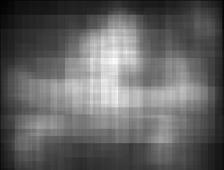
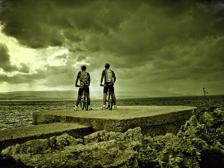
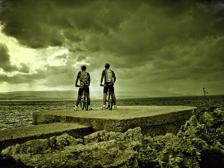
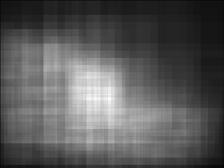
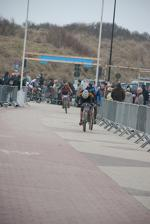
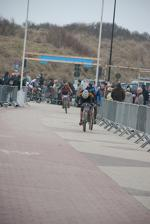
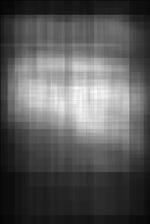
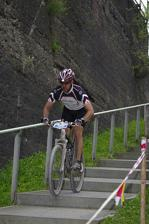
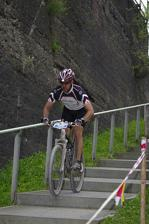
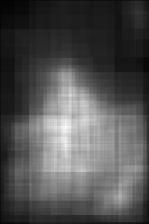
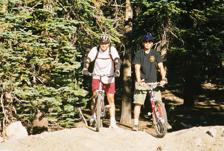
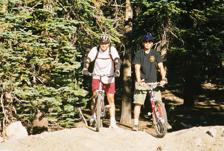
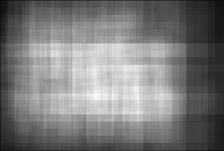
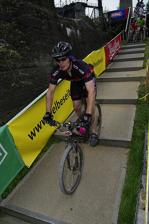
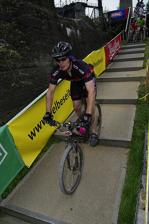
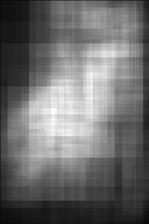
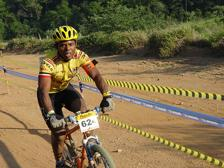
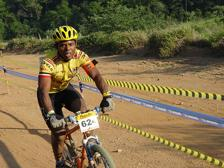
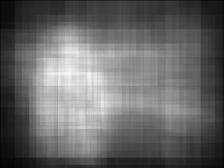
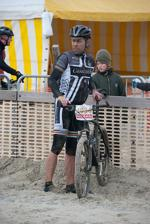
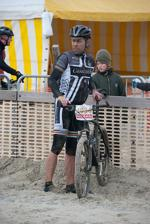
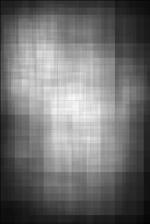

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import pandas as pd

def class_navigator():
    # Create all_misclass DataFrame by concatenating all model misclassification DataFrames
    all_misclass = pd.concat([base_misclass, global_misclass, heatmap_misclass], ignore_index=False)
    """
    Navigate through misclassifications by class using keyboard controls
    with model selection dropdown, misclassification counts, and top misclassification stats
    """
    # Available models
    model_options = ['All', 'Baseline', 'Global', 'Heatmap']
    
    # Create model selection dropdown
    model_dropdown = widgets.Dropdown(
        options=model_options,
        value='All',
        description='Model:',
        layout=widgets.Layout(width='30%')
    )
    
    # Create filter type radio buttons
    filter_type = widgets.RadioButtons(
        options=['True Class', 'Predicted Class'],
        value='True Class',
        description='Filter by:',
        layout=widgets.Layout(width='50%')
    )
    
    # Create slider for controlling max images
    image_count_slider = widgets.IntSlider(
        value=12,  # Default to 12 images
        min=1,
        max=50,
        step=1,
        description='Max images:',
        continuous_update=False,
        layout=widgets.Layout(width='40%')
    )
    
    # Variable to track current state
    current_model = 'All'
    class_idx = 0
    class_stats = {}  # Store misclassification statistics
    
    # Helper function to get misclassification stats for each class
    def create_class_options_with_stats(filtered_df, filter_type_value):
        stats = {}
        filter_column = 'true_name' if filter_type_value == 'True Class' else 'pred_name'
        other_column = 'pred_name' if filter_type_value == 'True Class' else 'true_name'
        
        # Get unique classes
        unique_classes = sorted(filtered_df[filter_column].unique().tolist())
        
        for cls in unique_classes:
            # Filter misclassifications for this class
            class_misclass = filtered_df[filtered_df[filter_column] == cls]
            total_count = len(class_misclass)
            
            # Count occurrences of each target class
            value_counts = class_misclass[other_column].value_counts()
            
            # Get top 3 misclassification targets and their counts
            top_3_targets = value_counts.head(3).to_dict() if not value_counts.empty else {}
            
            stats[cls] = {
                'total': total_count,
                'top_3': top_3_targets
            }
        
        # Format options for dropdown
        options = []
        for i, cls in enumerate(unique_classes):
            stat = stats[cls]
            top_3_counts = "/".join(str(count) for count in stat['top_3'].values())
            if top_3_counts:
                # Format: "Class name (total;counts)"
                label = f"{i+1}. {cls} ({stat['total']};{top_3_counts})"
            else:
                label = f"{i+1}. {cls} ({stat['total']})"
            options.append((label, i))
        
        return options, stats, unique_classes
    
    # Initially filter data for "All" models
    filtered_df = all_misclass.copy()
    # Initialize with empty values - will be populated in update_filter_classes
    classes = []
    num_classes = 0
    
    # Create navigation elements
    class_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=0,  # Will be updated later
        description='Class:',
        continuous_update=False,
        layout=widgets.Layout(width='50%')
    )
    
    # Fix: Initialize dropdown without a value since options are empty
    class_dropdown = widgets.Dropdown(
        options=[],  # Will be populated later
        description='Select:',
        layout=widgets.Layout(width='70%')  # Made wider to accommodate stats
    )
    
    prev_button = widgets.Button(description='← Previous Class')
    next_button = widgets.Button(description='Next Class →')
    info_text = widgets.HTML(value="")
    
    # Function to update filter classes based on filter type selection
    def update_filter_classes(filter_selection):
        nonlocal classes, num_classes, class_idx, class_stats
        
        # Store the current class name before changing filters
        current_class_name = classes[class_idx] if classes and 0 <= class_idx < len(classes) else None
        
        # Get class options with statistics
        dropdown_options, class_stats, classes = create_class_options_with_stats(filtered_df, filter_selection)
        num_classes = len(classes)
        
        # Update dropdown and slider options
        class_dropdown.options = dropdown_options
        class_slider.max = max(0, num_classes - 1)  # Ensure it doesn't go below 0
        
        # Try to maintain position - search for the same class name in the new filter
        if current_class_name and current_class_name in classes:
            class_idx = classes.index(current_class_name)
        else:
            # Only reset to first class if the previous class isn't found
            class_idx = 0
        
        # Update UI components if there are classes
        if num_classes > 0:
            class_slider.value = class_idx
            # Only set dropdown value after options are populated
            class_dropdown.value = class_idx
    
    # Function to update everything based on model selection
    def update_model(model_name):
        nonlocal current_model, class_idx, filtered_df, classes, num_classes
        
        # Save current class name for later
        current_class_name = classes[class_idx] if classes and 0 <= class_idx < len(classes) else None
        
        # Filter data by selected model
        if model_name == "All":
            filtered_df = all_misclass.copy()
        else:
            filtered_df = all_misclass[all_misclass['model'] == model_name].copy()
        
        # Update filter based on current filter type
        update_filter_classes(filter_type.value)
        
        # Try to maintain position in new class list
        if current_class_name and current_class_name in classes:
            class_idx = classes.index(current_class_name)
        else:
            class_idx = 0
            
        current_model = model_name
    
    # Function to display images for current class
    def display_current_class(class_idx):
        if num_classes == 0:
            info_text.value = f"<h3>No classes found for model: {current_model}</h3>"
            return
            
        current_class = classes[class_idx]
        filter_column = 'true_name' if filter_type.value == 'True Class' else 'pred_name'
        other_column = 'pred_name' if filter_type.value == 'True Class' else 'true_name'
        class_df = filtered_df[filtered_df[filter_column] == current_class]
        
        # Get misclassification statistics
        stats = class_stats.get(current_class, {})
        top_misclass_info = ""
        
        # Format top misclassifications details for display
        if 'top_3' in stats and stats['top_3']:
            top_misclass_info = "<p><b>Top misclassifications:</b><ul>"
            for cls, count in stats['top_3'].items():
                top_misclass_info += f"<li><b>{cls}</b>: {count} instances</li>"
            top_misclass_info += "</ul></p>"
        
        filter_label = filter_type.value.replace(' Class', '')
        info_text.value = f"<h3>{filter_label} Class {class_idx+1}/{num_classes}: {current_class}</h3>" \
                         f"<p>Found {len(class_df)} misclassifications for this class with model: {current_model}</p>" \
                         f"{top_misclass_info}"
        
        # Show sample images using the current max_images slider value
        if len(class_df) > 0:
            display_misclassified_images_with_heatmap(class_df, max_images=image_count_slider.value)
        else:
            print("No misclassifications for this class")
    
    # Define callbacks for UI elements
    def on_prev_click(b):
        nonlocal class_idx
        if num_classes > 0:
            class_idx = (class_idx - 1) % num_classes
            update_all(class_idx)
    
    def on_next_click(b):
        nonlocal class_idx
        if num_classes > 0:
            class_idx = (class_idx + 1) % num_classes
            update_all(class_idx)
    
    def on_slider_change(change):
        nonlocal class_idx
        class_idx = change['new']
        update_all(class_idx, source='slider')
    
    def on_dropdown_change(change):
        nonlocal class_idx
        class_idx = change['new']
        update_all(class_idx, source='dropdown')
    
    def on_model_change(change):
        update_model(change['new'])
        update_all(class_idx)
        
    def on_filter_type_change(change):
        # Update classes based on new filter type
        update_filter_classes(change['new'])
        
        # Use the current class idx (dropdown will be updated to match)
        update_all(class_idx)
        
    def on_image_count_change(change):
        # Just update the display with current class
        update_all(class_idx)
    
    def update_all(idx, source=None):
        # Update all UI components to reflect the current idx
        if num_classes > 0:
            if source != 'slider':
                class_slider.value = idx
            if source != 'dropdown':
                class_dropdown.value = idx
        
        # Clear previous output and display new class
        clear_output(wait=True)
        
        # Display settings controls in rows
        display(widgets.HBox([model_dropdown, filter_type]))
        display(widgets.HBox([image_count_slider]))
        display(widgets.HBox([class_dropdown, class_slider]))
        display(widgets.HBox([prev_button, next_button]))
        display(info_text)
        display_current_class(idx)
    
    # Connect callbacks
    prev_button.on_click(on_prev_click)
    next_button.on_click(on_next_click)
    class_slider.observe(on_slider_change, names='value')
    class_dropdown.observe(on_dropdown_change, names='value')
    model_dropdown.observe(on_model_change, names='value')
    filter_type.observe(on_filter_type_change, names='value')
    image_count_slider.observe(on_image_count_change, names='value')
    
    # Set up keyboard navigation
    keyboard_html = HTML("""
    <script>
    document.addEventListener('keydown', function(e) {
        if (e.key === 'ArrowLeft') {
            document.querySelector('.jupyter-button:first-child').click();
        } else if (e.key === 'ArrowRight') {
            document.querySelector('.jupyter-button:nth-child(2)').click();
        }
    });
    </script>
    """)
    
    # Initialize classes and UI
    update_filter_classes(filter_type.value)
    
    # Display the UI
    display(keyboard_html)
    update_all(0)
    
    print("Use ← and → arrow keys or the buttons to navigate between classes")

# Run the navigator
class_navigator()